# UniversityHack 2021 - Atmira Stock Prediction - Catboost

In [17]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import catboost as cb
#import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from IPython.display import clear_output

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import holidays

## Preprocessing of the original datasets
### Fill price in modelar dataset

In [2]:
# categoria_dos té 5844 nans a les categories uno E, A, H, F, però nan pot ser una altra categoria
# antiguedad té 862477 nans corresponents a 980 ids, no val la pena perquè està MOLT correlacionada amb els ids, 
# (-0.9417441) i aquests sí els podem conservar bé perquè no hi ha cap nan

In [166]:
df_mod = pd.read_csv(
    './../dades_originals/Modelar_UH2021.txt', sep='|', parse_dates=[0], dayfirst=True, decimal=",", 
    dtype = {4: 'object', 6: 'float', 9: 'Int64'}
)

In [185]:
def data_preprocessing_fill_price(df):
    total = len(df.id.unique())
    df_fill = df.copy()
    
    for i, pid in enumerate(df.id.unique()):
        # This product's entries
        df_prod = df_fill[df_fill.id == pid]

        # Fillforward, then back to cover the first few lines
        df_prod.loc[:,"precio"] = df_prod.loc[:,"precio"].fillna(method='ffill').fillna(method='bfill')
        
        # Save to DF
        df_fill.loc[df_prod.index] = df_prod

        clear_output(wait=True)
        print("Filled %.1f%% of the Dataframe" % (i/total * 100))
    
    return df_fill

In [186]:
df_mod = data_preprocessing_fill_price(df_mod)

Filled 100.0% of the Dataframe


In [189]:
df_mod.to_csv('./../dades_m/Modelar_UH2021_filled_precio.txt', sep='|')

### Read files with filled price

In [18]:
df_mod = pd.read_csv(
    './../dades_m/Modelar_UH2021_filled_precio.txt', sep='|', parse_dates=[1], index_col=0,
    dtype = {2: 'Int64', 3: 'Int64', 4: 'object', 5: 'object', 6: 'object', 7: 'float', 10: 'Int64'}
)

/home/muriel/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [19]:
df_est = pd.read_csv(
    './../dades_originals/Estimar2.txt', sep='|', parse_dates=[0], decimal=",", 
    dtype = {1: 'Int64', 2: 'Int64', 3: 'object', 4: 'object', 5: 'object', 6: 'float', 9: 'Int64'}
)

In [231]:
# "antiguedad" has a large number of NaNs (> 20% of data entries), 
# but we can simply remove the column because it highly correlated with "id"

In [20]:
len(df_mod[df_mod.antiguedad.isnull()] ) / len(df_mod)

0.21610883698531183

In [381]:
df_mod.corr()

,id,visitas,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
id,1.000000e+00,0.065406,0.392409,4.779027e-16,0.006483,-9.417391e-01,-0.054405
visitas,6.540614e-02,1.000000,0.091015,1.861653e-02,0.088389,-5.503825e-02,0.399514
precio,3.924095e-01,0.091015,1.000000,-1.423417e-03,0.006567,-3.507877e-01,-0.059487
dia_atipico,4.779027e-16,0.018617,-0.001423,1.000000e+00,0.133789,1.553115e-15,0.098565
campaña,6.482819e-03,0.088389,0.006567,1.337886e-01,1.000000,-7.216063e-03,0.125326
antiguedad,-9.417391e-01,-0.055038,-0.350788,1.553115e-15,-0.007216,1.000000e+00,0.061281
unidades_vendidas,-5.440536e-02,0.399514,-0.059487,9.856474e-02,0.125326,6.128106e-02,1.000000


In [382]:
# For control and visualization purposes I select a few reference products with a large and constant sales volume
agrupacio_id_mitjanes = df_mod.groupby("id")["unidades_vendidas"].mean()
agrupacio_id_std = df_mod.groupby("id")["unidades_vendidas"].std()
agrupacio_id_std_rel = agrupacio_id_std/agrupacio_id_mitjanes
reference_products_id = (agrupacio_id_mitjanes[agrupacio_id_mitjanes > 50]
                         [agrupacio_id_mitjanes[agrupacio_id_mitjanes > 50].index
                          .isin(agrupacio_id_std_rel[agrupacio_id_std_rel < 1].index)])
reference_products_id

id
86096     104.519507
171826     85.521561
171840    121.977413
259970     53.950719
333946     50.599589
Name: unidades_vendidas, dtype: float64

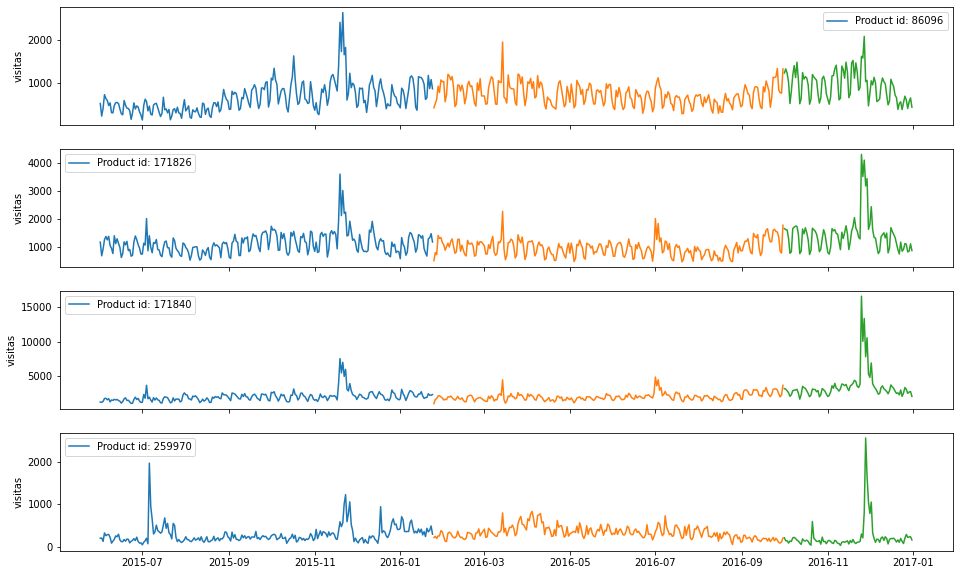

In [383]:
# Product 333946 is not in Estimar
fig, axs = plt.subplots(nrows=len(reference_products_id.index[:-1]), ncols=1, figsize=[16,10], sharex=True)
for i, idp in enumerate(reference_products_id.index[:-1]):
    axs[i].plot(df_mod.loc[(df_mod["id"] == idp) & (df_mod.fecha <= datetime.datetime(2016,1,24)), ].fecha, 
                5*df_mod.loc[(df_mod["id"] == idp) & (df_mod.fecha <= datetime.datetime(2016,1,24)), ].visitas)
    
    axs[i].plot(df_mod.loc[(df_mod["id"] == idp) & (df_mod.fecha > datetime.datetime(2016,1,24)), ].fecha, 
                df_mod.loc[(df_mod["id"] == idp) & (df_mod.fecha > datetime.datetime(2016,1,24)), ].visitas)
    axs[i].plot(df_est.loc[df_est["id"] == idp, ].fecha, df_est.loc[df_est["id"] == idp, ].visitas)
    axs[i].set(ylabel="visitas")
    axs[i].legend(["Product id: "+ str(idp)])

In [58]:
def data_preprocessing_3(df_original):
    df = df_original.copy()
    
    # General cleaning
    print('Dropping duplicates, including those for campaign days (and keeping entries with campaña = 1)')
#    df = df.drop_duplicates()
    df = df.sort_values(["id", "fecha", "campaña"]).drop_duplicates(["fecha", "id"], keep="last")
    df = df.reset_index(drop=True)
    df = df.drop(['antiguedad'], axis=1, errors='ignore')

    # Convert categoria_dos NaNs from Modelar and Estimar to the same string
    df["categoria_dos"] = df["categoria_dos"].fillna("-")                 # Modelar
#    df.loc[df["categoria_dos"] == "-", "categoria_dos"] = "nan"          # Estimar
        
    print('Fixing dates')
    df.loc[df.fecha.dt.year == 2015, "fecha"] = df["fecha"] + pd.offsets.DateOffset(year=2018)
    df.loc[df.fecha.dt.year == 2016, "fecha"] = df["fecha"] + pd.offsets.DateOffset(year=2019)

    print('Fixing visits')
    df['visitas_scl'] = np.where( (df['fecha'] <= datetime.datetime(2019,1,24)) , 
                                   df["visitas"]*5, df["visitas"]*1)
    df["visitas_scl"] = pd.to_numeric(df['visitas_scl'])

    # Cyclical week and month spinners
    df_weekday = df.fecha.dt.weekday
    df_month = df["fecha"].dt.day / df["fecha"].dt.days_in_month
    df_year = (df["fecha"].dt.month - 1) + (df["fecha"].dt.day / df["fecha"].dt.days_in_month)
    
    df['weekday_sin'] = np.sin(df_weekday * (2*np.pi/7))
    df['weekday_cos'] = np.cos(df_weekday * (2*np.pi/7))
    df['month_sin'] = np.sin(df_month * (2*np.pi))
    df['month_cos'] = np.cos(df_month * (2*np.pi))
    df['year_sin'] = np.sin((df_year-1) * (2*np.pi/12))
    df['year_cos'] = np.cos((df_year-1) * (2*np.pi/12))

    # Adding year
    df['year'] = df.fecha.dt.year

    print('Clearing NANs')
    df.dropna(how='any', inplace=True)
    
    return df

In [59]:
df_mod = data_preprocessing_3(df_mod)

Dropping duplicates, including those for campaign days (and keeping entries with campaña = 1)
Fixing dates


/home/muriel/.local/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
/home/muriel/.local/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(


Fixing visits
Clearing NANs


In [60]:
df_est = data_preprocessing_3(df_est)

Dropping duplicates, including those for campaign days (and keeping entries with campaña = 1)
Fixing dates


/home/muriel/.local/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
/home/muriel/.local/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(


Fixing visits
Clearing NANs


In [64]:
df_mod.to_csv('./../dades_m/Modelar_UH2021_process3.txt', sep='|')

In [65]:
df_est.to_csv('./../dades_m/Estimar2_process3.txt', sep='|')

----
### Read already pre-processed data files

In [175]:
df_mod2 = pd.read_csv('./../dades_m/Modelar_UH2021_process3.txt',sep='|', parse_dates=[1], index_col=0, 
                      dtype = {5: 'object'}
#                      dtype = {1: 'Int64', 2: 'Int64', 3: 'object', 4: 'object', 6: 'float', 9: 'Int64'}
                     )

/home/muriel/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [176]:
df_est2 = pd.read_csv('./../dades_m/Estimar2_process3.txt',sep='|', parse_dates=[1], index_col=0, 
                      dtype = {5: 'object'})

In [61]:
df_mod2 = df_mod
df_est2 = df_est

In [177]:
df_mod2["weekday"] = df_mod2.fecha.dt.weekday
df_est2["weekday"] = df_est2.fecha.dt.weekday
df_mod2["month"] = df_mod2.fecha.dt.month
df_est2["month"] = df_est2.fecha.dt.month

In [178]:
day_zero = min(df_mod2["fecha"])
df_mod2["days_passed"] = (df_mod2["fecha"]-day_zero).dt.days
df_est2["days_passed"] = (df_est2["fecha"]-day_zero).dt.days

In [623]:
#df_mod2 = df_mod2.drop(["visitas", "fecha", "categoria_uno"], axis=1)
#df_est2 = df_est2.drop(["visitas", "fecha", "categoria_uno"], axis=1)

----
## Catboost (all categories together)

### Calculation of date for dataset split in train and validation

In [179]:
# Percentage of the newest entries from the training dataset to reserve for validation
test_size_time_series = 0.2
test_number_days = round(len(df_mod2.fecha.unique())*test_size_time_series)
test_date_threshold = sorted(df_mod2.fecha.unique())[len(df_mod2.fecha.unique())-test_number_days]

### Adding more features

In [180]:
# Adding features average and standard deviation of unidades_vendidas of the training dataset for each product
unidades_vendidas_mean_data = df_mod2[(df_mod2.fecha < test_date_threshold)
                                     ].groupby("id").mean()["unidades_vendidas"].rename("unidades_vendidas_mean")
unidades_vendidas_std_data = df_mod2[(df_mod2.fecha < test_date_threshold)
                                     ].groupby("id").std()["unidades_vendidas"].rename("unidades_vendidas_std")
unidades_vendidas_std_norm_data = (unidades_vendidas_std_data / unidades_vendidas_mean_data
                                  ).rename("unidades_vendidas_std_norm")

unidades_vendidas_data = pd.concat([unidades_vendidas_mean_data, unidades_vendidas_std_data, 
                                    unidades_vendidas_std_norm_data], axis=1)
df_mod2 = pd.merge(df_mod2, unidades_vendidas_data, on=["id"], how="left")

In [181]:
# Adding features average and standard deviation of unidades_vendidas of the training dataset for each product
# also on the test set
df_est2 = pd.merge(df_est2, unidades_vendidas_data, on=["id"], how="left")

In [182]:
# Adding feature day with 50% more of overall visits than the average
visitas_totales_mean_train = df_mod2[(df_mod2.fecha < test_date_threshold)
                                     ].groupby("fecha").sum()["unidades_vendidas"].rename("unidades_vendidas_mean")
visitas_totales_dia_train = df_mod2.groupby("fecha").sum()["visitas_scl"]
dia_mas_visitas_train = (visitas_totales_dia_train >= 1.5*( df_mod2[(df_mod2.fecha < test_date_threshold)]
                              .groupby("fecha").sum()["visitas_scl"].mean() ) ).rename("dia_mas_visitas")
df_mod2 = pd.merge(df_mod2, dia_mas_visitas_train, on=["fecha"], how="left")

In [183]:
# Adding feature day with 50% more of overall visits than the average also for test set
visitas_totales_dia_test = df_est2.groupby("fecha").sum()["visitas_scl"]
dia_mas_visitas_test = (visitas_totales_dia_test >= 1.5*( df_mod2[(df_mod2.fecha < test_date_threshold)]
                              .groupby("fecha").sum()["visitas_scl"].mean() ) ).rename("dia_mas_visitas")
df_est2 = pd.merge(df_est2, dia_mas_visitas_test, on=["fecha"], how="left")

In [ ]:
# Adding features tendency of unidades_vendidas of the training dataset for each product

In [196]:
# IDEES FEATURES TODO
# Afegir un feature per producte que sigui la mitjana de les (compres/visites) per cada dia, 
# si les visites són 0 aleshores, posar-hi les compres*(-1)

# Afegir la categoria de vacances/festius. Adding feature "is_blackfriday", "cyber_monday" "is_pcdays" and ""
# Thanksgiving = fourth Thursday in November, Black friday dia següent
# Afegir les holidays
holidays.ESP(years=2018)
(holidays.US(years=2018).get_named("Thanksgiving")[0]+datetime.timedelta(days=1), 
 holidays.US(years=2019).get_named("Thanksgiving")[0]+datetime.timedelta(days=1))
# Es poden afegir les vacances també que són només de certes comunitats autònomes amb una etiqueta diferent

# Per cada producte fer una regressió lineal de les vendes en funció de la data, 
# i afegir com a features els paràmetres del pendent i del terme independent de la recta 
# això traient les dades dels dies especials i sense treure'ls

(datetime.date(2018, 11, 23), datetime.date(2019, 11, 29))

### Choose which columns to use, label categorical features, and split dataset in train and validation

In [194]:
#X = df_mod2[df_mod2.columns.difference(["unidades_vendidas"])].copy()
column_order = ['fecha', 'days_passed', 
                'weekday', 'visitas_scl', 
                "unidades_vendidas_std_norm", #'unidades_vendidas_std', 'unidades_vendidas_mean',
                'campaña', 'dia_atipico', 'categoria_dos',  'estado', 'precio', 
                'id', 'month_cos', 'month_sin',  # "visitas", "categoria_uno", "month",
                'year_cos', 'year_sin', #'weekday_cos', 'weekday_sin', 'year', "dia_mas_visitas",
               ]
X = df_mod2[column_order].copy()
#X = df_mod2[df_mod2.columns.difference(["unidades_vendidas"])].copy()
y = df_mod2['unidades_vendidas'].copy()

categorical_features = ["categoria_dos", "estado", "dia_atipico", "campaña", "id", "weekday", 
                       ] # "month", "dia_mas_visitas"
for col in categorical_features:
    X[col] = X[col].astype('category')

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=0)

X_train = X[X.fecha < test_date_threshold].drop(columns=["fecha"])
y_train = y[X.fecha < test_date_threshold].drop(columns=["fecha"])

X_val = X[X.fecha >= test_date_threshold].drop(columns=["fecha"])
y_val = y[X.fecha >= test_date_threshold].drop(columns=["fecha"])

train_dataset = cb.Pool(X_train, y_train, cat_features = categorical_features)
val_dataset = cb.Pool(X_val, y_val, cat_features = categorical_features)

### Model and data combinations already tried

3,14    3,29  -> 'weekday', 'visitas_scl', 'campaña', 'dia_atipico', 'categoria_dos',  'estado', 'precio', 'id', 'month_cos', 'month_sin', 'year_cos', 'year_sin'

3,1    3,27 -> 'days_passed', 'weekday', 'visitas_scl', 'campaña', 'dia_atipico', 'categoria_dos',  'estado', 'precio', 'id', 'month_cos', 'month_sin', 'year_cos', 'year_sin'

+ bootstrap_type='Bayesian',
2.70, 4.20 -> 

+ bootstrap_type='Bernouilli',
2,69     3,90

+ grow_policy ="Depthwise", 
1.98     4.32  

+ grow_policy ="Lossguide", 
2.04     4.23

+ bootstrap_type='Poisson', i sense grow_policy
2.65     4.03

+ bootstrap_type='MVS', sense grow_policy, amb CPU (la GPU no ho permet, potser canvien altres coses soles)
2.14     4.43
---
+ bootstrap_type='Bernouilli', amb CPU (potser canvien altres coses)
2.24     4,10
---
+ bootstrap_type='Bernouilli', GPU, min_data_in_leaf = 2, ->  (no canvia res)
2,69     3,90

+ bootstrap_type='Bernouilli', GPU, depth = 8,
2.68     3.76

+ bootstrap_type='Bernouilli', GPU, depth = 10,
2.70     3.73

+ bootstrap_type='Bernouilli', GPU, depth = 12,
2.70     3.71

+ bootstrap_type='Bernouilli', GPU, depth = 16,
2.79     3.74

+ bootstrap_type='Bernouilli', GPU, depth = 16, min_data_in_leaf = 4, 20 o 1000 no canvia res
2.80     3.74

+ bootstrap_type='Bernouilli', GPU, depth = 10, min_data_in_leaf = 2, one_hot_max_size = 200,
2,77     3,84

+ bootstrap_type='Bernouilli', GPU, depth = 10, min_data_in_leaf = 2, one_hot_max_size = 4,
2,53     3,97

+ bootstrap_type='Bernouilli', GPU, depth = 12, min_data_in_leaf = 2, boosting_type= "ordered"  
2.80     3.73

+ bootstrap_type='Bernouilli', GPU, depth = 12, subsample = 0.8, 
2.70     3.71

+ bootstrap_type='Bernouilli', GPU, depth = 12, subsample = 0.2, 
2.75     3.78
---
- "days-passed
2.71     3.71

- "days-passed - "month_sin" - "month_cos"
2.67     3.80

- "month_sin" - "month_cos" -'year_cos' -'year_sin' -> provar-ho amb days_passed in l'any però sense el mes
2.77      3.80 

+ bootstrap_type='Bernouilli', GPU, depth = 12, id numèric (no categòric)
2.88     4.87

+ bootstrap_type='Bernouilli', GPU, depth = 12, has_time=True, 
3.33     3.93

+ bootstrap_type='Bernouilli', GPU, depth = 12, weekday categòric
2.80     3,61

+ bootstrap_type='Bernouilli', GPU, depth = 12, weekday categòric, mean i std unidades vendidas
2.64     3.49

+ bootstrap_type='Bernouilli', GPU, depth = 12, weekday i month categòrics, mean i std unidades vendidas,
2.65     3.61

+ bootstrap_type='Bernouilli', GPU, depth = 12, weekday i month categòrics -monthcos-monthsin, mean i std unidades vendidas,
2.69     3.57

+ bootstrap_type='Bernouilli', GPU, depth = 12, weekday categòrics, + mean i std unidades vendidas, arreglant visitas_scl
2.45     3.02

+ bootstrap_type='Bernouilli', GPU, depth = 12, weekday categòrics, + mean i std unidades vendidas, arreglant visitas_scl, + dia_mas_visitas, 
2.52     3.04

+ bootstrap_type='Bernouilli', GPU, depth = 12, weekday categòrics, + std_norm unidades vendidas (-mean, -std), arreglant visitas_scl
2.60     3.18
---
Conclusions:
* bootstrap_type = "Bernouilli"
* GPU
* depth = 12 (11? 13?)
* month millor no categòric sinó cíclic

### Build and train model

In [195]:
# Model with weekday and unidades vendidas mean and std 9-4-2021 15h45
model = cb.CatBoostRegressor(random_state=0, iterations=1000, verbose=50, 
                             bootstrap_type='Bernoulli', task_type='GPU', depth= 12,
                             learning_rate=0.9, 
                             # subsample = 0.6600000262260437, 'use_best_model': False, 'min_fold_size': 100,
                             # eval_metric=MetricaAtmira(), loss_function='RMSE',  bootstrap_type='Bayesian',
                             # grow_policy ="Lossguide", grow_policy ="Depthwise", 'permutation_count': 4,
                             # fold_size_loss_normalization': False, boosting_type= "ordered",
                             # max_leaves = 65536, max_ctr_complexity = 4, model_size_reg = 0.5,
                             # one_hot_max_size = 4, l2_leaf_reg= 3, random_strength = 1 (només CPU), 
                             # min_data_in_leaf = 2, subsample = 0.66,  has_time=True, 
                            )
# User defined loss_function and metric not supported for GPU:  
model.fit(X_train, y_train, categorical_features, early_stopping_rounds=20, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 15.7136027	total: 548ms	remaining: 9m 6s
50:	learn: 10.4156645	total: 33s	remaining: 10m 14s
100:	learn: 9.4013098	total: 1m 4s	remaining: 9m 30s
150:	learn: 8.8433794	total: 1m 35s	remaining: 8m 56s
200:	learn: 8.4317714	total: 2m 8s	remaining: 8m 29s
250:	learn: 8.1274677	total: 2m 39s	remaining: 7m 55s
300:	learn: 7.8691899	total: 3m 10s	remaining: 7m 22s
350:	learn: 7.5829316	total: 3m 43s	remaining: 6m 53s
400:	learn: 7.3870413	total: 4m 16s	remaining: 6m 22s
450:	learn: 7.2348645	total: 4m 49s	remaining: 5m 52s
500:	learn: 7.0885441	total: 5m 21s	remaining: 5m 19s
550:	learn: 6.9707029	total: 5m 52s	remaining: 4m 47s
600:	learn: 6.8548139	total: 6m 25s	remaining: 4m 15s
650:	learn: 6.7759352	total: 6m 57s	remaining: 3m 43s
700:	learn: 6.7017942	total: 7m 29s	remaining: 3m 11s
750:	learn: 6.5955739	total: 8m 1s	remaining: 2m 39s
800:	learn: 6.5132785	total: 8m 34s	remaining: 2m 7s
850:	learn: 6.4303646	total: 9m 6s	remaining: 1m 35s
900:	learn: 6.3589399	total: 9m 38s	re

In [707]:
model.save_model("models/catboost_2021-4-9_16h45.model")

### Evaluate model

In [78]:
def metrica_atmira(y_test, y_predicted):
    rmse = mean_squared_error(y_test, y_predicted, squared=False)
    rrmse = rmse/y_test.mean()
    # Si el valor és negatiu és que hi ha hagut més demanda de la prevista, si el valor és positiu compta com a CF
    diferencia = y_predicted - y_test
    CF = np.sum(diferencia >= 0)/len(y_test)
    metrica_minimitzar = (0.7*rrmse) + (0.3*(1-CF))
    print("rmse = ", rmse)
    print("y_mean = ", y_test.mean())
    print("rrmse = ", rrmse)
    print("CF =", CF)
    return metrica_minimitzar

In [77]:
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)   
    feature_names = np.array(names)   
    data={'feature_names':feature_names, 'feature_importance':feature_importance}   
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    plt.figure(figsize=(10,8))   
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])   
    plt.title(model_type + ' FEATURE IMPORTANCE')   
    plt.xlabel('FEATURE IMPORTANCE')   
    plt.ylabel('FEATURE NAMES')

In [197]:
y_trainp = model.predict(X_train)

In [198]:
y_pred2 = model.predict(X_val)

In [199]:
# Miro la mètrica Atmiar de la predicció de les dades d'entrenamnt
metrica_atmira(y_train, y_trainp)  #+1)

rmse =  12.31017243737425
y_mean =  3.4919201240218514
rrmse =  3.5253304772607157
CF = 0.5739092721098479


2.5955585524495466

In [200]:
# Miro la mètrica Atmira de la predicció de les dades de validació
metrica_atmira(y_val, y_pred2)    #+1)

rmse =  14.9996408491257
y_mean =  3.448550072224311
rrmse =  4.34954996592262
CF = 0.5539035755980767


3.1785139034664107

In [201]:
df_train2 = X_train.copy()
df_train2["unidades_vendidas"] = y_train
df_train2["prediction"] = y_trainp

In [202]:
df_val2 = X_val.copy()
df_val2["unidades_vendidas"] = y_val
df_val2["prediction"] = y_pred2

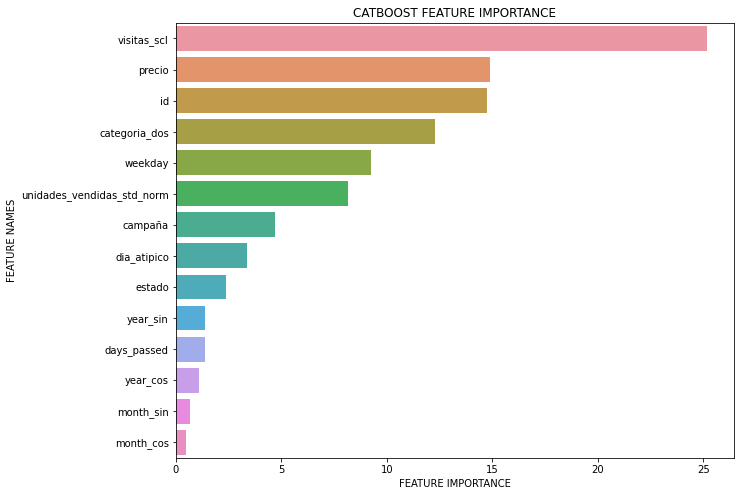

In [203]:
plot_feature_importance(model.get_feature_importance(),X_train.columns,'CATBOOST')

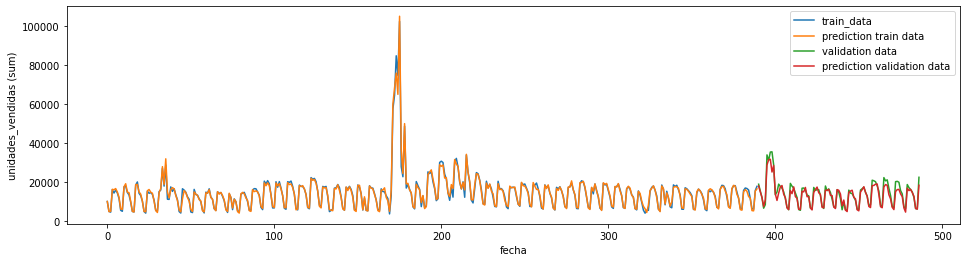

In [204]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[16,4])
#axs.plot(df_val.groupby("fecha").sum().index, df_val.groupby("fecha").sum()["unidades_vendidas"])
#axs.plot(df_val.groupby("fecha").sum().index, df_val.groupby("fecha").sum()["prediction"])
#axs.plot(df_val2.groupby("fecha").sum().index, df_val2.groupby("fecha").sum()["unidades_vendidas"])
#axs.plot(df_val2.groupby("fecha").sum().index, df_val2.groupby("fecha").sum()["prediction"])
#axs.plot(df_train2.groupby("fecha").sum().index, df_train2.groupby("fecha").sum()["unidades_vendidas"])
#axs.plot(df_train2.groupby("fecha").sum().index, df_train2.groupby("fecha").sum()["prediction"])

axs.plot(df_train2.groupby("days_passed").sum().index, df_train2.groupby("days_passed").sum()["unidades_vendidas"])
axs.plot(df_train2.groupby("days_passed").sum().index, df_train2.groupby("days_passed").sum()["prediction"])
axs.plot(df_val2.groupby("days_passed").sum().index, df_val2.groupby("days_passed").sum()["unidades_vendidas"])
axs.plot(df_val2.groupby("days_passed").sum().index, df_val2.groupby("days_passed").sum()["prediction"])

axs.set(xlabel="fecha", ylabel="unidades_vendidas (sum)")
axs.legend(["train_data", "prediction train data", "validation data", "prediction validation data"])

## END
---
## Catboost custom evaluation metric and loss function (half done)

In [630]:
# Catboost custom evaluation metric
class MetricaAtmira(object):
    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        for i in range(len(approx)):
            error_sum += ((approx[i] - target[i])**2)

        mitjana = np.mean(target)
        rRMSE = ( np.sqrt(error_sum/len(target)) )/ mitjana

        # Si el valor de la diferència és negatiu és que hi ha hagut més demanda de la prevista, 
        # si és positiu o zero compta com a CF
        diferencia = approx - target
        CF = np.sum(diferencia >= 0)/len(target)

        metrica_atmira = 0.7*( rRMSE ) + (0.3 * (1 - CF))
        
        weight_sum = 1.
        
        return metrica_atmira, weight_sum
    
    def get_final_error(self, error, weight):
        return error

In [ ]:
# Define custom loss (TODO: needs to compute the derivatives)
class AtmiraLoss(object):
    def calc_ders_range(self, approxes, targets, weights):
        # This function should return a list of pairs (der1, der2), where
        # der1 is the first derivative of the loss function with respect
        # to the predicted value, and der2 is the second derivative.
        result = []
        for index in range(len(targets)):
            der1 = 2*(targets[index] - approxes[index]) ## First Derivative of Loss Function
            der2 = -1                                   ## Second Derivative of Loss Function

            result.append((der1, der2))

        return result

----
## Catboost by categories (disregarded)

### Before splitting dataset in categories

In [607]:
categorical_features = ["categoria_dos", "estado", "dia_atipico", "campaña"]
for col in categorical_features:
    df_mod2[col] = df_mod2[col].astype('category')

In [608]:
df = df_mod2

----
### Split dataset in categories

In [609]:
# Split dataset in categorias_uno and limit number of training samples per categoria_uno
number_samples_desired = 1000000

list_categoria_uno = sorted( df["categoria_uno"].unique() )
data_cat = [None]*len(list_categoria_uno)
data_est_cat = [None]*len(list_categoria_uno)

for index in range(len(list_categoria_uno)):

    number_samples = number_samples_desired
    number_samples_available = len(df[df["categoria_uno"] == list_categoria_uno[index]])
    if number_samples_desired > number_samples_available:
        number_samples = number_samples_available
        print(f"Only {number_samples_available} samples for categoria_uno = {list_categoria_uno[index]}")
        
    # Modelar
    data_cat[index] = df[df["categoria_uno"] == list_categoria_uno[index]].sample(n=number_samples, 
                                                                                          random_state=0)
    data_cat[index] = data_cat[index].drop(columns = "categoria_uno")
    # Estimar
    data_est_cat[index] = df_est2[df_est2["categoria_uno"] == list_categoria_uno[index]]
    data_est_cat[index] = data_est_cat[index].drop(columns = "categoria_uno")

Only 674982 samples for categoria_uno = A
Only 51622 samples for categoria_uno = B
Only 163632 samples for categoria_uno = C
Only 487 samples for categoria_uno = D
Only 160223 samples for categoria_uno = E
Only 279538 samples for categoria_uno = F
Only 84251 samples for categoria_uno = G
Only 198209 samples for categoria_uno = H
Only 36525 samples for categoria_uno = I
Only 319472 samples for categoria_uno = K
Only 53083 samples for categoria_uno = L
Only 4383 samples for categoria_uno = N
Only 3409 samples for categoria_uno = O


## Train / test split

In [610]:
X = [None]*len(list_categoria_uno)
y = [None]*len(list_categoria_uno)
X_train = [None]*len(list_categoria_uno)
X_test = [None]*len(list_categoria_uno)
y_train = [None]*len(list_categoria_uno)
y_test = [None]*len(list_categoria_uno)
train_pool = [None]*len(list_categoria_uno)
test_pool = [None]*len(list_categoria_uno)

for index in range(len(list_categoria_uno)):
    X[index] = data_cat[index][data_cat[index].columns.difference(["unidades_vendidas"])]
    y[index] = data_cat[index]["unidades_vendidas"]
    
    X_train[index], X_test[index], y_train[index], y_test[index] = train_test_split(
                                                            X[index], y[index], test_size=0.10, random_state=0)
    
    train_pool[index] = cb.Pool(X_train[index], y_train[index], cat_features = categorical_features)
    test_pool[index] = cb.Pool(X_test[index], y_test[index], cat_features = categorical_features)

print(X[0].shape, y[0].shape)
print(len(X_train[0]), len(y_train[0]), len(X_test[0]))
print(X_train[0].shape, y_train[0].shape, X_test[0].shape)

(674982, 14) (674982,)
607483 607483 67499
(607483, 14) (607483,) (67499, 14)


In [70]:
# (NO MILLORA) Use for training only data from typical days and without campaigns (test data is left untouched)
#index_typical = [None]*len(list_categoria_uno)

#for cat_index in range(len(list_categoria_uno)):
#    index_typical[cat_index] = X_train[cat_index].loc[(X_train[cat_index]["dia_atipico"] == 0) & 
#                                                       (X_train[cat_index]["campaña"] == 0), ].index
#    X_train[cat_index] = X_train[cat_index][X_train[cat_index].index.isin(index_typical[cat_index])]
#    y_train[cat_index] = y_train[cat_index][y_train[cat_index].index.isin(index_typical[cat_index])]

## Normalitzation of selected features

In [611]:
# Normalize some features of the train and test datasets with the Standard Scaler/Robust Scaler 
# Select which columns to use with the scaler

selected_columns = [
#    "fecha",
#    "id",
#    "antiguedad_std",
#    "campaña",
#    "categoria_uno",
#    "categoria_dos",
#    "dia_atipico",
#    "estado_num",
#    "month_cos",
#    "month_sin",
    "precio",
#    "visitas",
#    "weekday",
#    "weekday_cos",
#    "weekday_sin",
#    "visitas_dia_antes",
#    "visitas_7_dias_antes",
    ] 

In [612]:
# I train the scaler with ALL training data available
scaler = StandardScaler().fit(df.loc[:,selected_columns])
#scaler = RobustScaler().fit(df.loc[:,selected_columns])

X_train_scaled = [None]*len(list_categoria_uno)
X_train_non_scaled = [None]*len(list_categoria_uno)
X_test_scaled = [None]*len(list_categoria_uno)
X_test_non_scaled = [None]*len(list_categoria_uno)

for index in range(len(list_categoria_uno)):
    X_train_scaled[index] = scaler.transform(X_train[index].loc[:, selected_columns])
    X_train_non_scaled[index] = X_train[index][X_train[index].columns.difference(selected_columns)]
    X_train_scaled[index] = np.concatenate([X_train_non_scaled[index], X_train_scaled[index]], axis=1)

    X_test_scaled[index] = scaler.transform(X_test[index].loc[:, selected_columns])
    X_test_non_scaled[index] = X_test[index][X_test[index].columns.difference(selected_columns)]
    X_test_scaled[index] = np.concatenate([X_test_non_scaled[index], X_test_scaled[index]], axis=1)

## Train models and predict test and validation samples

In [619]:
print("Start training: ", datetime.datetime.now())

predictor = [None]*len(list_categoria_uno)
y_train_predicted = [None]*len(list_categoria_uno)
y_test_predicted = [None]*len(list_categoria_uno)

for index in range(len(list_categoria_uno)):
#    predictor[index] = LinearSVR(random_state=0, tol=1e-5, max_iter=10000)
#    predictor[index] = SVR(kernel='rbf', C=2., tol=1e-5, max_iter=100000)
#    predictor[index] = RandomForestRegressor(max_depth=7, random_state=0)
    predictor[index] = cb.CatBoostRegressor(task_type='GPU', random_state=1, iterations=1000)  #loss_function
#    predictor[index] = RandomForestRegressor(max_depth=4, n_estimators=200, random_state=0)
    print(f"{index+1}/{len(list_categoria_uno)}\n{predictor[index]}")

#    predictor[index].fit(X_train_scaled[index], y_train[index])              # other
#    predictor[index].fit(train_pool[index], test_pool[index], categorical_features)     # catboost
    predictor[index].fit(X_train[index], y_train[index], categorical_features)     # catboost

    y_train_predicted[index] = predictor[index].predict(X_train_scaled[index])
    y_test_predicted[index] = predictor[index].predict(X_test_scaled[index])

print("End training: ", datetime.datetime.now())

Start training:  2021-04-08 16:42:16.887689
1/13
Learning rate set to 0.089986
0:	learn: 18.4054713	total: 69.3ms	remaining: 1m 9s
1:	learn: 18.4040116	total: 148ms	remaining: 1m 13s
2:	learn: 18.4035043	total: 228ms	remaining: 1m 15s
3:	learn: 18.4000113	total: 291ms	remaining: 1m 12s
4:	learn: 18.3990808	total: 351ms	remaining: 1m 9s
5:	learn: 18.3933754	total: 450ms	remaining: 1m 14s
6:	learn: 18.3889215	total: 557ms	remaining: 1m 18s
7:	learn: 18.3792912	total: 605ms	remaining: 1m 15s
8:	learn: 18.3792547	total: 663ms	remaining: 1m 12s
9:	learn: 18.3694300	total: 710ms	remaining: 1m 10s
10:	learn: 18.3673451	total: 775ms	remaining: 1m 9s
11:	learn: 18.3669544	total: 856ms	remaining: 1m 10s
12:	learn: 18.3664367	total: 907ms	remaining: 1m 8s
13:	learn: 18.3584983	total: 985ms	remaining: 1m 9s
14:	learn: 18.3464080	total: 1.07s	remaining: 1m 10s
15:	learn: 18.3411048	total: 1.13s	remaining: 1m 9s
16:	learn: 18.3405074	total: 1.24s	remaining: 1m 11s
17:	learn: 18.3393837	total: 1.3s	r

154:	learn: 18.1641587	total: 12.3s	remaining: 1m 7s
155:	learn: 18.1589096	total: 12.4s	remaining: 1m 7s
156:	learn: 18.1587762	total: 12.5s	remaining: 1m 6s
157:	learn: 18.1580988	total: 12.5s	remaining: 1m 6s
158:	learn: 18.1578841	total: 12.6s	remaining: 1m 6s
159:	learn: 18.1577333	total: 12.7s	remaining: 1m 6s
160:	learn: 18.1572321	total: 12.8s	remaining: 1m 6s
161:	learn: 18.1570682	total: 12.8s	remaining: 1m 6s
162:	learn: 18.1570421	total: 12.9s	remaining: 1m 6s
163:	learn: 18.1568695	total: 13s	remaining: 1m 6s
164:	learn: 18.1565938	total: 13s	remaining: 1m 5s
165:	learn: 18.1565365	total: 13.1s	remaining: 1m 5s
166:	learn: 18.1564879	total: 13.2s	remaining: 1m 5s
167:	learn: 18.1562515	total: 13.3s	remaining: 1m 5s
168:	learn: 18.1561978	total: 13.4s	remaining: 1m 5s
169:	learn: 18.1561325	total: 13.4s	remaining: 1m 5s
170:	learn: 18.1561050	total: 13.5s	remaining: 1m 5s
171:	learn: 18.1505082	total: 13.6s	remaining: 1m 5s
172:	learn: 18.1501534	total: 13.7s	remaining: 1m 

313:	learn: 18.0926674	total: 24.4s	remaining: 53.3s
314:	learn: 18.0925837	total: 24.4s	remaining: 53.1s
315:	learn: 18.0925007	total: 24.5s	remaining: 53s
316:	learn: 18.0924905	total: 24.6s	remaining: 52.9s
317:	learn: 18.0924061	total: 24.6s	remaining: 52.8s
318:	learn: 18.0913317	total: 24.7s	remaining: 52.8s
319:	learn: 18.0913135	total: 24.8s	remaining: 52.7s
320:	learn: 18.0912771	total: 24.9s	remaining: 52.6s
321:	learn: 18.0911206	total: 24.9s	remaining: 52.5s
322:	learn: 18.0910806	total: 25s	remaining: 52.4s
323:	learn: 18.0910187	total: 25.1s	remaining: 52.3s
324:	learn: 18.0909940	total: 25.2s	remaining: 52.2s
325:	learn: 18.0901073	total: 25.2s	remaining: 52.2s
326:	learn: 18.0892898	total: 25.3s	remaining: 52.1s
327:	learn: 18.0892636	total: 25.4s	remaining: 52.1s
328:	learn: 18.0891165	total: 25.5s	remaining: 52s
329:	learn: 18.0890816	total: 25.5s	remaining: 51.8s
330:	learn: 18.0887663	total: 25.6s	remaining: 51.7s
331:	learn: 18.0880077	total: 25.7s	remaining: 51.6s

471:	learn: 18.0532453	total: 35.9s	remaining: 40.2s
472:	learn: 18.0532387	total: 36s	remaining: 40.1s
473:	learn: 18.0528506	total: 36s	remaining: 40s
474:	learn: 18.0527908	total: 36.1s	remaining: 39.9s
475:	learn: 18.0527215	total: 36.2s	remaining: 39.8s
476:	learn: 18.0526106	total: 36.2s	remaining: 39.7s
477:	learn: 18.0526041	total: 36.3s	remaining: 39.6s
478:	learn: 18.0525807	total: 36.4s	remaining: 39.6s
479:	learn: 18.0525041	total: 36.4s	remaining: 39.5s
480:	learn: 18.0524523	total: 36.5s	remaining: 39.4s
481:	learn: 18.0524283	total: 36.5s	remaining: 39.3s
482:	learn: 18.0524159	total: 36.6s	remaining: 39.2s
483:	learn: 18.0524064	total: 36.6s	remaining: 39.1s
484:	learn: 18.0523385	total: 36.7s	remaining: 39s
485:	learn: 18.0523072	total: 36.8s	remaining: 38.9s
486:	learn: 18.0521357	total: 36.9s	remaining: 38.8s
487:	learn: 18.0521299	total: 36.9s	remaining: 38.7s
488:	learn: 18.0521139	total: 37s	remaining: 38.6s
489:	learn: 18.0520526	total: 37s	remaining: 38.5s
490:	

627:	learn: 18.0256455	total: 45.6s	remaining: 27s
628:	learn: 18.0256331	total: 45.6s	remaining: 26.9s
629:	learn: 18.0254059	total: 45.7s	remaining: 26.8s
630:	learn: 18.0253760	total: 45.7s	remaining: 26.7s
631:	learn: 18.0251488	total: 45.8s	remaining: 26.7s
632:	learn: 18.0251137	total: 45.9s	remaining: 26.6s
633:	learn: 18.0250479	total: 45.9s	remaining: 26.5s
634:	learn: 18.0250377	total: 46s	remaining: 26.4s
635:	learn: 18.0249771	total: 46s	remaining: 26.3s
636:	learn: 18.0247688	total: 46.1s	remaining: 26.3s
637:	learn: 18.0245891	total: 46.1s	remaining: 26.2s
638:	learn: 18.0245241	total: 46.2s	remaining: 26.1s
639:	learn: 18.0234325	total: 46.3s	remaining: 26s
640:	learn: 18.0228458	total: 46.3s	remaining: 25.9s
641:	learn: 18.0226894	total: 46.4s	remaining: 25.9s
642:	learn: 18.0226346	total: 46.4s	remaining: 25.8s
643:	learn: 18.0224300	total: 46.5s	remaining: 25.7s
644:	learn: 18.0223438	total: 46.5s	remaining: 25.6s
645:	learn: 18.0221925	total: 46.6s	remaining: 25.5s
6

783:	learn: 18.0017084	total: 55s	remaining: 15.1s
784:	learn: 18.0016631	total: 55s	remaining: 15.1s
785:	learn: 18.0015014	total: 55.1s	remaining: 15s
786:	learn: 18.0014882	total: 55.1s	remaining: 14.9s
787:	learn: 18.0014846	total: 55.2s	remaining: 14.8s
788:	learn: 18.0014699	total: 55.3s	remaining: 14.8s
789:	learn: 18.0013982	total: 55.3s	remaining: 14.7s
790:	learn: 18.0013580	total: 55.4s	remaining: 14.6s
791:	learn: 18.0013397	total: 55.5s	remaining: 14.6s
792:	learn: 18.0013031	total: 55.5s	remaining: 14.5s
793:	learn: 18.0011868	total: 55.6s	remaining: 14.4s
794:	learn: 18.0011751	total: 55.6s	remaining: 14.3s
795:	learn: 18.0010486	total: 55.7s	remaining: 14.3s
796:	learn: 18.0009995	total: 55.8s	remaining: 14.2s
797:	learn: 18.0003909	total: 55.8s	remaining: 14.1s
798:	learn: 18.0003396	total: 55.9s	remaining: 14.1s
799:	learn: 18.0003257	total: 55.9s	remaining: 14s
800:	learn: 18.0002321	total: 56s	remaining: 13.9s
801:	learn: 18.0002153	total: 56.1s	remaining: 13.8s
802

941:	learn: 17.9422092	total: 1m 5s	remaining: 4.02s
942:	learn: 17.9422004	total: 1m 5s	remaining: 3.95s
943:	learn: 17.9421843	total: 1m 5s	remaining: 3.88s
944:	learn: 17.9420646	total: 1m 5s	remaining: 3.81s
945:	learn: 17.9420566	total: 1m 5s	remaining: 3.74s
946:	learn: 17.9418672	total: 1m 5s	remaining: 3.67s
947:	learn: 17.9416808	total: 1m 5s	remaining: 3.61s
948:	learn: 17.9416771	total: 1m 5s	remaining: 3.54s
949:	learn: 17.9416565	total: 1m 5s	remaining: 3.47s
950:	learn: 17.9415046	total: 1m 6s	remaining: 3.4s
951:	learn: 17.9411750	total: 1m 6s	remaining: 3.33s
952:	learn: 17.9411611	total: 1m 6s	remaining: 3.26s
953:	learn: 17.9411552	total: 1m 6s	remaining: 3.19s
954:	learn: 17.9411508	total: 1m 6s	remaining: 3.12s
955:	learn: 17.9411163	total: 1m 6s	remaining: 3.05s
956:	learn: 17.9410275	total: 1m 6s	remaining: 2.98s
957:	learn: 17.9409049	total: 1m 6s	remaining: 2.92s
958:	learn: 17.9408021	total: 1m 6s	remaining: 2.85s
959:	learn: 17.9407794	total: 1m 6s	remaining: 

108:	learn: 5.1243712	total: 1.89s	remaining: 15.4s
109:	learn: 5.1243544	total: 1.91s	remaining: 15.5s
110:	learn: 5.1243360	total: 1.93s	remaining: 15.5s
111:	learn: 5.1238750	total: 1.95s	remaining: 15.4s
112:	learn: 5.1221282	total: 1.97s	remaining: 15.5s
113:	learn: 5.1221054	total: 1.98s	remaining: 15.4s
114:	learn: 5.1219480	total: 2s	remaining: 15.4s
115:	learn: 5.1219470	total: 2.02s	remaining: 15.4s
116:	learn: 5.1128786	total: 2.05s	remaining: 15.5s
117:	learn: 5.1122421	total: 2.06s	remaining: 15.4s
118:	learn: 5.1122084	total: 2.08s	remaining: 15.4s
119:	learn: 5.1121950	total: 2.09s	remaining: 15.3s
120:	learn: 5.1116492	total: 2.1s	remaining: 15.2s
121:	learn: 5.1116487	total: 2.11s	remaining: 15.2s
122:	learn: 5.1043366	total: 2.14s	remaining: 15.2s
123:	learn: 5.1030909	total: 2.16s	remaining: 15.2s
124:	learn: 5.1030492	total: 2.18s	remaining: 15.3s
125:	learn: 5.1029844	total: 2.2s	remaining: 15.2s
126:	learn: 5.1029680	total: 2.21s	remaining: 15.2s
127:	learn: 5.102

278:	learn: 4.9921194	total: 4.58s	remaining: 11.8s
279:	learn: 4.9914928	total: 4.61s	remaining: 11.9s
280:	learn: 4.9914440	total: 4.63s	remaining: 11.9s
281:	learn: 4.9913025	total: 4.64s	remaining: 11.8s
282:	learn: 4.9912990	total: 4.66s	remaining: 11.8s
283:	learn: 4.9855047	total: 4.69s	remaining: 11.8s
284:	learn: 4.9854717	total: 4.71s	remaining: 11.8s
285:	learn: 4.9854075	total: 4.72s	remaining: 11.8s
286:	learn: 4.9854075	total: 4.74s	remaining: 11.8s
287:	learn: 4.9803643	total: 4.77s	remaining: 11.8s
288:	learn: 4.9798919	total: 4.79s	remaining: 11.8s
289:	learn: 4.9798703	total: 4.8s	remaining: 11.8s
290:	learn: 4.9796966	total: 4.82s	remaining: 11.7s
291:	learn: 4.9790155	total: 4.84s	remaining: 11.7s
292:	learn: 4.9790095	total: 4.86s	remaining: 11.7s
293:	learn: 4.9790074	total: 4.87s	remaining: 11.7s
294:	learn: 4.9770886	total: 4.9s	remaining: 11.7s
295:	learn: 4.9770722	total: 4.92s	remaining: 11.7s
296:	learn: 4.9770713	total: 4.93s	remaining: 11.7s
297:	learn: 4.

452:	learn: 4.9539888	total: 7.05s	remaining: 8.51s
453:	learn: 4.9539882	total: 7.05s	remaining: 8.48s
454:	learn: 4.9539771	total: 7.07s	remaining: 8.46s
455:	learn: 4.9539752	total: 7.08s	remaining: 8.45s
456:	learn: 4.9539464	total: 7.1s	remaining: 8.43s
457:	learn: 4.9539334	total: 7.11s	remaining: 8.42s
458:	learn: 4.9539331	total: 7.12s	remaining: 8.39s
459:	learn: 4.9539326	total: 7.13s	remaining: 8.37s
460:	learn: 4.9527949	total: 7.14s	remaining: 8.35s
461:	learn: 4.9527525	total: 7.16s	remaining: 8.34s
462:	learn: 4.9525906	total: 7.18s	remaining: 8.33s
463:	learn: 4.9525906	total: 7.19s	remaining: 8.3s
464:	learn: 4.9525906	total: 7.2s	remaining: 8.28s
465:	learn: 4.9525659	total: 7.21s	remaining: 8.27s
466:	learn: 4.9525485	total: 7.23s	remaining: 8.25s
467:	learn: 4.9525480	total: 7.24s	remaining: 8.22s
468:	learn: 4.9506187	total: 7.26s	remaining: 8.22s
469:	learn: 4.9501646	total: 7.28s	remaining: 8.21s
470:	learn: 4.9498271	total: 7.3s	remaining: 8.2s
471:	learn: 4.949

624:	learn: 4.9086634	total: 9.32s	remaining: 5.59s
625:	learn: 4.9086379	total: 9.34s	remaining: 5.58s
626:	learn: 4.9083181	total: 9.37s	remaining: 5.57s
627:	learn: 4.9083172	total: 9.37s	remaining: 5.55s
628:	learn: 4.9083131	total: 9.38s	remaining: 5.54s
629:	learn: 4.9082923	total: 9.4s	remaining: 5.52s
630:	learn: 4.9082909	total: 9.41s	remaining: 5.5s
631:	learn: 4.9082621	total: 9.41s	remaining: 5.48s
632:	learn: 4.9082619	total: 9.42s	remaining: 5.46s
633:	learn: 4.9082575	total: 9.44s	remaining: 5.45s
634:	learn: 4.9080201	total: 9.46s	remaining: 5.44s
635:	learn: 4.9078129	total: 9.48s	remaining: 5.42s
636:	learn: 4.9078124	total: 9.48s	remaining: 5.4s
637:	learn: 4.9078124	total: 9.49s	remaining: 5.38s
638:	learn: 4.9078124	total: 9.5s	remaining: 5.37s
639:	learn: 4.9077822	total: 9.52s	remaining: 5.35s
640:	learn: 4.9077817	total: 9.53s	remaining: 5.33s
641:	learn: 4.9077767	total: 9.54s	remaining: 5.32s
642:	learn: 4.9077161	total: 9.56s	remaining: 5.31s
643:	learn: 4.90

794:	learn: 4.8960939	total: 11.6s	remaining: 2.98s
795:	learn: 4.8960939	total: 11.6s	remaining: 2.97s
796:	learn: 4.8959266	total: 11.6s	remaining: 2.96s
797:	learn: 4.8959263	total: 11.6s	remaining: 2.94s
798:	learn: 4.8959261	total: 11.6s	remaining: 2.92s
799:	learn: 4.8959206	total: 11.6s	remaining: 2.91s
800:	learn: 4.8959192	total: 11.7s	remaining: 2.89s
801:	learn: 4.8959192	total: 11.7s	remaining: 2.88s
802:	learn: 4.8959170	total: 11.7s	remaining: 2.86s
803:	learn: 4.8959173	total: 11.7s	remaining: 2.85s
804:	learn: 4.8959151	total: 11.7s	remaining: 2.83s
805:	learn: 4.8959019	total: 11.7s	remaining: 2.82s
806:	learn: 4.8955675	total: 11.7s	remaining: 2.81s
807:	learn: 4.8950057	total: 11.8s	remaining: 2.79s
808:	learn: 4.8949632	total: 11.8s	remaining: 2.78s
809:	learn: 4.8947372	total: 11.8s	remaining: 2.77s
810:	learn: 4.8947293	total: 11.8s	remaining: 2.75s
811:	learn: 4.8947290	total: 11.8s	remaining: 2.74s
812:	learn: 4.8947276	total: 11.8s	remaining: 2.72s
813:	learn: 

960:	learn: 4.8720979	total: 14s	remaining: 570ms
961:	learn: 4.8720966	total: 14s	remaining: 555ms
962:	learn: 4.8720968	total: 14.1s	remaining: 540ms
963:	learn: 4.8720968	total: 14.1s	remaining: 525ms
964:	learn: 4.8720966	total: 14.1s	remaining: 511ms
965:	learn: 4.8720819	total: 14.1s	remaining: 496ms
966:	learn: 4.8720703	total: 14.1s	remaining: 482ms
967:	learn: 4.8720085	total: 14.1s	remaining: 467ms
968:	learn: 4.8720082	total: 14.1s	remaining: 452ms
969:	learn: 4.8720076	total: 14.1s	remaining: 437ms
970:	learn: 4.8719897	total: 14.2s	remaining: 423ms
971:	learn: 4.8718207	total: 14.2s	remaining: 408ms
972:	learn: 4.8718207	total: 14.2s	remaining: 394ms
973:	learn: 4.8718207	total: 14.2s	remaining: 379ms
974:	learn: 4.8718207	total: 14.2s	remaining: 364ms
975:	learn: 4.8718210	total: 14.2s	remaining: 350ms
976:	learn: 4.8718022	total: 14.2s	remaining: 335ms
977:	learn: 4.8717649	total: 14.2s	remaining: 320ms
978:	learn: 4.8713971	total: 14.3s	remaining: 306ms
979:	learn: 4.87

121:	learn: 20.1160693	total: 2.29s	remaining: 16.5s
122:	learn: 20.1158938	total: 2.31s	remaining: 16.5s
123:	learn: 20.1157338	total: 2.33s	remaining: 16.5s
124:	learn: 20.1155394	total: 2.35s	remaining: 16.5s
125:	learn: 20.1099735	total: 2.37s	remaining: 16.4s
126:	learn: 20.1084762	total: 2.39s	remaining: 16.4s
127:	learn: 20.1084134	total: 2.41s	remaining: 16.4s
128:	learn: 20.1082777	total: 2.42s	remaining: 16.4s
129:	learn: 20.1015836	total: 2.44s	remaining: 16.3s
130:	learn: 20.1009309	total: 2.46s	remaining: 16.4s
131:	learn: 20.1007451	total: 2.48s	remaining: 16.3s
132:	learn: 20.1004850	total: 2.5s	remaining: 16.3s
133:	learn: 20.1001904	total: 2.52s	remaining: 16.3s
134:	learn: 20.1000661	total: 2.55s	remaining: 16.3s
135:	learn: 20.0968288	total: 2.57s	remaining: 16.3s
136:	learn: 20.0967700	total: 2.59s	remaining: 16.3s
137:	learn: 20.0967538	total: 2.6s	remaining: 16.3s
138:	learn: 20.0906162	total: 2.63s	remaining: 16.3s
139:	learn: 20.0859379	total: 2.65s	remaining: 1

283:	learn: 19.9902705	total: 5.44s	remaining: 13.7s
284:	learn: 19.9900402	total: 5.46s	remaining: 13.7s
285:	learn: 19.9898968	total: 5.48s	remaining: 13.7s
286:	learn: 19.9898173	total: 5.5s	remaining: 13.7s
287:	learn: 19.9896189	total: 5.52s	remaining: 13.6s
288:	learn: 19.9895415	total: 5.53s	remaining: 13.6s
289:	learn: 19.9895218	total: 5.55s	remaining: 13.6s
290:	learn: 19.9895055	total: 5.57s	remaining: 13.6s
291:	learn: 19.9894552	total: 5.59s	remaining: 13.5s
292:	learn: 19.9894158	total: 5.61s	remaining: 13.5s
293:	learn: 19.9893384	total: 5.64s	remaining: 13.5s
294:	learn: 19.9892446	total: 5.66s	remaining: 13.5s
295:	learn: 19.9891590	total: 5.68s	remaining: 13.5s
296:	learn: 19.9889885	total: 5.7s	remaining: 13.5s
297:	learn: 19.9887187	total: 5.72s	remaining: 13.5s
298:	learn: 19.9884375	total: 5.75s	remaining: 13.5s
299:	learn: 19.9874978	total: 5.76s	remaining: 13.4s
300:	learn: 19.9865336	total: 5.79s	remaining: 13.4s
301:	learn: 19.9862224	total: 5.8s	remaining: 13

443:	learn: 19.9511395	total: 8.61s	remaining: 10.8s
444:	learn: 19.9507923	total: 8.62s	remaining: 10.8s
445:	learn: 19.9507801	total: 8.64s	remaining: 10.7s
446:	learn: 19.9507563	total: 8.66s	remaining: 10.7s
447:	learn: 19.9501259	total: 8.67s	remaining: 10.7s
448:	learn: 19.9500578	total: 8.69s	remaining: 10.7s
449:	learn: 19.9500381	total: 8.71s	remaining: 10.6s
450:	learn: 19.9492784	total: 8.73s	remaining: 10.6s
451:	learn: 19.9492287	total: 8.74s	remaining: 10.6s
452:	learn: 19.9487004	total: 8.76s	remaining: 10.6s
453:	learn: 19.9485077	total: 8.78s	remaining: 10.6s
454:	learn: 19.9458750	total: 8.79s	remaining: 10.5s
455:	learn: 19.9458436	total: 8.81s	remaining: 10.5s
456:	learn: 19.9457551	total: 8.83s	remaining: 10.5s
457:	learn: 19.9457504	total: 8.84s	remaining: 10.5s
458:	learn: 19.9457483	total: 8.86s	remaining: 10.4s
459:	learn: 19.9440542	total: 8.87s	remaining: 10.4s
460:	learn: 19.9438792	total: 8.89s	remaining: 10.4s
461:	learn: 19.9438057	total: 8.91s	remaining:

601:	learn: 19.9117079	total: 11.5s	remaining: 7.6s
602:	learn: 19.9117052	total: 11.5s	remaining: 7.58s
603:	learn: 19.9107769	total: 11.5s	remaining: 7.56s
604:	learn: 19.9107469	total: 11.5s	remaining: 7.54s
605:	learn: 19.9097183	total: 11.6s	remaining: 7.52s
606:	learn: 19.9088288	total: 11.6s	remaining: 7.5s
607:	learn: 19.9087790	total: 11.6s	remaining: 7.48s
608:	learn: 19.9087633	total: 11.6s	remaining: 7.46s
609:	learn: 19.9077823	total: 11.6s	remaining: 7.44s
610:	learn: 19.9077257	total: 11.7s	remaining: 7.42s
611:	learn: 19.9067556	total: 11.7s	remaining: 7.4s
612:	learn: 19.9066922	total: 11.7s	remaining: 7.38s
613:	learn: 19.9066281	total: 11.7s	remaining: 7.36s
614:	learn: 19.9065687	total: 11.7s	remaining: 7.35s
615:	learn: 19.9065264	total: 11.8s	remaining: 7.33s
616:	learn: 19.9064364	total: 11.8s	remaining: 7.31s
617:	learn: 19.9064145	total: 11.8s	remaining: 7.29s
618:	learn: 19.9063456	total: 11.8s	remaining: 7.28s
619:	learn: 19.9061485	total: 11.9s	remaining: 7.

759:	learn: 19.8799648	total: 14.7s	remaining: 4.63s
760:	learn: 19.8796560	total: 14.7s	remaining: 4.61s
761:	learn: 19.8795836	total: 14.7s	remaining: 4.59s
762:	learn: 19.8795392	total: 14.7s	remaining: 4.57s
763:	learn: 19.8794463	total: 14.7s	remaining: 4.55s
764:	learn: 19.8794066	total: 14.8s	remaining: 4.54s
765:	learn: 19.8792946	total: 14.8s	remaining: 4.51s
766:	learn: 19.8792024	total: 14.8s	remaining: 4.5s
767:	learn: 19.8791122	total: 14.8s	remaining: 4.48s
768:	learn: 19.8788997	total: 14.8s	remaining: 4.46s
769:	learn: 19.8788273	total: 14.9s	remaining: 4.44s
770:	learn: 19.8781332	total: 14.9s	remaining: 4.42s
771:	learn: 19.8780977	total: 14.9s	remaining: 4.4s
772:	learn: 19.8780280	total: 14.9s	remaining: 4.38s
773:	learn: 19.8779112	total: 14.9s	remaining: 4.36s
774:	learn: 19.8778346	total: 15s	remaining: 4.34s
775:	learn: 19.8777315	total: 15s	remaining: 4.32s
776:	learn: 19.8775088	total: 15s	remaining: 4.3s
777:	learn: 19.8774309	total: 15s	remaining: 4.29s
778:

915:	learn: 19.8615861	total: 17.8s	remaining: 1.63s
916:	learn: 19.8615820	total: 17.8s	remaining: 1.61s
917:	learn: 19.8615485	total: 17.8s	remaining: 1.59s
918:	learn: 19.8615396	total: 17.8s	remaining: 1.57s
919:	learn: 19.8614774	total: 17.8s	remaining: 1.55s
920:	learn: 19.8614316	total: 17.9s	remaining: 1.53s
921:	learn: 19.8613495	total: 17.9s	remaining: 1.51s
922:	learn: 19.8612825	total: 17.9s	remaining: 1.49s
923:	learn: 19.8609947	total: 17.9s	remaining: 1.47s
924:	learn: 19.8609112	total: 17.9s	remaining: 1.46s
925:	learn: 19.8608374	total: 18s	remaining: 1.44s
926:	learn: 19.8607683	total: 18s	remaining: 1.42s
927:	learn: 19.8607239	total: 18s	remaining: 1.4s
928:	learn: 19.8606425	total: 18s	remaining: 1.38s
929:	learn: 19.8605413	total: 18s	remaining: 1.36s
930:	learn: 19.8604941	total: 18.1s	remaining: 1.34s
931:	learn: 19.8604545	total: 18.1s	remaining: 1.32s
932:	learn: 19.8603163	total: 18.1s	remaining: 1.3s
933:	learn: 19.8602438	total: 18.1s	remaining: 1.28s
934:	

78:	learn: 5.5217155	total: 1.37s	remaining: 16s
79:	learn: 5.5146633	total: 1.39s	remaining: 16s
80:	learn: 5.5102322	total: 1.4s	remaining: 15.9s
81:	learn: 5.5039081	total: 1.42s	remaining: 15.9s
82:	learn: 5.5009361	total: 1.44s	remaining: 15.9s
83:	learn: 5.4952079	total: 1.45s	remaining: 15.8s
84:	learn: 5.4918521	total: 1.47s	remaining: 15.8s
85:	learn: 5.4896726	total: 1.48s	remaining: 15.8s
86:	learn: 5.4871218	total: 1.5s	remaining: 15.7s
87:	learn: 5.4853926	total: 1.51s	remaining: 15.7s
88:	learn: 5.4836866	total: 1.53s	remaining: 15.6s
89:	learn: 5.4812022	total: 1.54s	remaining: 15.6s
90:	learn: 5.4755445	total: 1.56s	remaining: 15.6s
91:	learn: 5.4693228	total: 1.57s	remaining: 15.5s
92:	learn: 5.4683843	total: 1.59s	remaining: 15.5s
93:	learn: 5.4656574	total: 1.6s	remaining: 15.4s
94:	learn: 5.4638991	total: 1.61s	remaining: 15.4s
95:	learn: 5.4609638	total: 1.63s	remaining: 15.3s
96:	learn: 5.4565887	total: 1.64s	remaining: 15.2s
97:	learn: 5.4536288	total: 1.65s	rema

239:	learn: 5.1237021	total: 3.86s	remaining: 12.2s
240:	learn: 5.1168247	total: 3.88s	remaining: 12.2s
241:	learn: 5.1168134	total: 3.89s	remaining: 12.2s
242:	learn: 5.1102757	total: 3.91s	remaining: 12.2s
243:	learn: 5.1040617	total: 3.93s	remaining: 12.2s
244:	learn: 5.1040326	total: 3.95s	remaining: 12.2s
245:	learn: 5.1040060	total: 3.96s	remaining: 12.1s
246:	learn: 5.1039815	total: 3.98s	remaining: 12.1s
247:	learn: 5.1039610	total: 3.99s	remaining: 12.1s
248:	learn: 5.1037590	total: 4s	remaining: 12.1s
249:	learn: 5.1035720	total: 4.02s	remaining: 12.1s
250:	learn: 5.1035506	total: 4.03s	remaining: 12s
251:	learn: 5.1035292	total: 4.05s	remaining: 12s
252:	learn: 5.1033527	total: 4.06s	remaining: 12s
253:	learn: 5.1031895	total: 4.08s	remaining: 12s
254:	learn: 5.1031692	total: 4.1s	remaining: 12s
255:	learn: 5.1030165	total: 4.11s	remaining: 11.9s
256:	learn: 5.1028742	total: 4.12s	remaining: 11.9s
257:	learn: 5.0969557	total: 4.14s	remaining: 11.9s
258:	learn: 5.0913282	tota

407:	learn: 4.9393364	total: 6.1s	remaining: 8.86s
408:	learn: 4.9393019	total: 6.11s	remaining: 8.84s
409:	learn: 4.9391588	total: 6.13s	remaining: 8.82s
410:	learn: 4.9390310	total: 6.14s	remaining: 8.81s
411:	learn: 4.9389985	total: 6.16s	remaining: 8.79s
412:	learn: 4.9388843	total: 6.17s	remaining: 8.77s
413:	learn: 4.9388337	total: 6.18s	remaining: 8.75s
414:	learn: 4.9388035	total: 6.19s	remaining: 8.73s
415:	learn: 4.9387746	total: 6.2s	remaining: 8.71s
416:	learn: 4.9387462	total: 6.21s	remaining: 8.69s
417:	learn: 4.9386073	total: 6.22s	remaining: 8.66s
418:	learn: 4.9384848	total: 6.23s	remaining: 8.64s
419:	learn: 4.9383764	total: 6.24s	remaining: 8.62s
420:	learn: 4.9382807	total: 6.25s	remaining: 8.59s
421:	learn: 4.9381960	total: 6.26s	remaining: 8.57s
422:	learn: 4.9381859	total: 6.26s	remaining: 8.54s
423:	learn: 4.9381768	total: 6.27s	remaining: 8.52s
424:	learn: 4.9381017	total: 6.28s	remaining: 8.5s
425:	learn: 4.9380355	total: 6.29s	remaining: 8.47s
426:	learn: 4.9

574:	learn: 4.8376711	total: 8.15s	remaining: 6.03s
575:	learn: 4.8371065	total: 8.16s	remaining: 6.01s
576:	learn: 4.8365764	total: 8.18s	remaining: 6s
577:	learn: 4.8360780	total: 8.19s	remaining: 5.98s
578:	learn: 4.8360773	total: 8.2s	remaining: 5.96s
579:	learn: 4.8360766	total: 8.21s	remaining: 5.95s
580:	learn: 4.8360762	total: 8.22s	remaining: 5.93s
581:	learn: 4.8356352	total: 8.23s	remaining: 5.91s
582:	learn: 4.8355363	total: 8.24s	remaining: 5.89s
583:	learn: 4.8351337	total: 8.25s	remaining: 5.88s
584:	learn: 4.8350429	total: 8.26s	remaining: 5.86s
585:	learn: 4.8346754	total: 8.28s	remaining: 5.85s
586:	learn: 4.8343405	total: 8.29s	remaining: 5.83s
587:	learn: 4.8340357	total: 8.31s	remaining: 5.82s
588:	learn: 4.8337576	total: 8.32s	remaining: 5.81s
589:	learn: 4.8337511	total: 8.34s	remaining: 5.79s
590:	learn: 4.8337451	total: 8.34s	remaining: 5.77s
591:	learn: 4.8337396	total: 8.36s	remaining: 5.76s
592:	learn: 4.8337350	total: 8.37s	remaining: 5.74s
593:	learn: 4.83

743:	learn: 4.7839735	total: 10.4s	remaining: 3.58s
744:	learn: 4.7839693	total: 10.4s	remaining: 3.56s
745:	learn: 4.7839299	total: 10.4s	remaining: 3.55s
746:	learn: 4.7839199	total: 10.4s	remaining: 3.54s
747:	learn: 4.7839101	total: 10.5s	remaining: 3.52s
748:	learn: 4.7838989	total: 10.5s	remaining: 3.51s
749:	learn: 4.7838945	total: 10.5s	remaining: 3.49s
750:	learn: 4.7838907	total: 10.5s	remaining: 3.48s
751:	learn: 4.7838798	total: 10.5s	remaining: 3.46s
752:	learn: 4.7838763	total: 10.5s	remaining: 3.45s
753:	learn: 4.7838672	total: 10.5s	remaining: 3.43s
754:	learn: 4.7838663	total: 10.5s	remaining: 3.42s
755:	learn: 4.7838651	total: 10.5s	remaining: 3.4s
756:	learn: 4.7838644	total: 10.5s	remaining: 3.38s
757:	learn: 4.7838635	total: 10.6s	remaining: 3.37s
758:	learn: 4.7838597	total: 10.6s	remaining: 3.35s
759:	learn: 4.7838490	total: 10.6s	remaining: 3.34s
760:	learn: 4.7838458	total: 10.6s	remaining: 3.33s
761:	learn: 4.7838360	total: 10.6s	remaining: 3.31s
762:	learn: 4

907:	learn: 4.7227539	total: 12.4s	remaining: 1.26s
908:	learn: 4.7226994	total: 12.4s	remaining: 1.24s
909:	learn: 4.7225879	total: 12.4s	remaining: 1.23s
910:	learn: 4.7225412	total: 12.5s	remaining: 1.22s
911:	learn: 4.7224388	total: 12.5s	remaining: 1.2s
912:	learn: 4.7223878	total: 12.5s	remaining: 1.19s
913:	learn: 4.7222931	total: 12.5s	remaining: 1.18s
914:	learn: 4.7222065	total: 12.5s	remaining: 1.16s
915:	learn: 4.7221616	total: 12.5s	remaining: 1.15s
916:	learn: 4.7221144	total: 12.6s	remaining: 1.14s
917:	learn: 4.7220337	total: 12.6s	remaining: 1.12s
918:	learn: 4.7219926	total: 12.6s	remaining: 1.11s
919:	learn: 4.7219699	total: 12.6s	remaining: 1.09s
920:	learn: 4.7219494	total: 12.6s	remaining: 1.08s
921:	learn: 4.7219286	total: 12.6s	remaining: 1.07s
922:	learn: 4.7217832	total: 12.6s	remaining: 1.05s
923:	learn: 4.7217078	total: 12.7s	remaining: 1.04s
924:	learn: 4.7216956	total: 12.7s	remaining: 1.03s
925:	learn: 4.7216259	total: 12.7s	remaining: 1.01s
926:	learn: 4

65:	learn: 17.2722244	total: 1.26s	remaining: 17.9s
66:	learn: 17.2718864	total: 1.28s	remaining: 17.8s
67:	learn: 17.2692860	total: 1.31s	remaining: 17.9s
68:	learn: 17.2629834	total: 1.33s	remaining: 17.9s
69:	learn: 17.2627793	total: 1.34s	remaining: 17.9s
70:	learn: 17.2626275	total: 1.36s	remaining: 17.8s
71:	learn: 17.2625246	total: 1.38s	remaining: 17.8s
72:	learn: 17.2561424	total: 1.4s	remaining: 17.8s
73:	learn: 17.2556923	total: 1.42s	remaining: 17.7s
74:	learn: 17.2552366	total: 1.44s	remaining: 17.7s
75:	learn: 17.2550365	total: 1.45s	remaining: 17.7s
76:	learn: 17.2514326	total: 1.48s	remaining: 17.7s
77:	learn: 17.2484303	total: 1.49s	remaining: 17.6s
78:	learn: 17.2387566	total: 1.51s	remaining: 17.6s
79:	learn: 17.2285759	total: 1.53s	remaining: 17.6s
80:	learn: 17.2106836	total: 1.55s	remaining: 17.6s
81:	learn: 17.2100574	total: 1.57s	remaining: 17.6s
82:	learn: 17.2088050	total: 1.59s	remaining: 17.6s
83:	learn: 17.2065836	total: 1.61s	remaining: 17.6s
84:	learn: 17

229:	learn: 17.0349058	total: 4.39s	remaining: 14.7s
230:	learn: 17.0348480	total: 4.42s	remaining: 14.7s
231:	learn: 17.0329549	total: 4.44s	remaining: 14.7s
232:	learn: 17.0328548	total: 4.46s	remaining: 14.7s
233:	learn: 17.0292691	total: 4.47s	remaining: 14.6s
234:	learn: 17.0290402	total: 4.5s	remaining: 14.7s
235:	learn: 17.0289539	total: 4.52s	remaining: 14.6s
236:	learn: 17.0047436	total: 4.55s	remaining: 14.7s
237:	learn: 17.0024156	total: 4.58s	remaining: 14.7s
238:	learn: 17.0018005	total: 4.6s	remaining: 14.7s
239:	learn: 17.0017320	total: 4.62s	remaining: 14.6s
240:	learn: 17.0005221	total: 4.64s	remaining: 14.6s
241:	learn: 16.9986717	total: 4.66s	remaining: 14.6s
242:	learn: 16.9986220	total: 4.68s	remaining: 14.6s
243:	learn: 16.9983666	total: 4.69s	remaining: 14.5s
244:	learn: 16.9983095	total: 4.71s	remaining: 14.5s
245:	learn: 16.9968048	total: 4.73s	remaining: 14.5s
246:	learn: 16.9946838	total: 4.75s	remaining: 14.5s
247:	learn: 16.9945753	total: 4.76s	remaining: 1

385:	learn: 16.8685552	total: 7.3s	remaining: 11.6s
386:	learn: 16.8685322	total: 7.32s	remaining: 11.6s
387:	learn: 16.8683349	total: 7.33s	remaining: 11.6s
388:	learn: 16.8679361	total: 7.36s	remaining: 11.6s
389:	learn: 16.8670390	total: 7.38s	remaining: 11.5s
390:	learn: 16.8670299	total: 7.39s	remaining: 11.5s
391:	learn: 16.8669000	total: 7.41s	remaining: 11.5s
392:	learn: 16.8668194	total: 7.42s	remaining: 11.5s
393:	learn: 16.8667553	total: 7.43s	remaining: 11.4s
394:	learn: 16.8666492	total: 7.45s	remaining: 11.4s
395:	learn: 16.8666221	total: 7.47s	remaining: 11.4s
396:	learn: 16.8664724	total: 7.48s	remaining: 11.4s
397:	learn: 16.8663211	total: 7.5s	remaining: 11.3s
398:	learn: 16.8663006	total: 7.52s	remaining: 11.3s
399:	learn: 16.8662372	total: 7.54s	remaining: 11.3s
400:	learn: 16.8661928	total: 7.56s	remaining: 11.3s
401:	learn: 16.8661714	total: 7.57s	remaining: 11.3s
402:	learn: 16.8660292	total: 7.58s	remaining: 11.2s
403:	learn: 16.8654807	total: 7.6s	remaining: 11

549:	learn: 16.8432275	total: 10s	remaining: 8.18s
550:	learn: 16.8431509	total: 10s	remaining: 8.16s
551:	learn: 16.8431295	total: 10s	remaining: 8.15s
552:	learn: 16.8430884	total: 10.1s	remaining: 8.13s
553:	learn: 16.8430192	total: 10.1s	remaining: 8.11s
554:	learn: 16.8430184	total: 10.1s	remaining: 8.09s
555:	learn: 16.8428710	total: 10.1s	remaining: 8.07s
556:	learn: 16.8428388	total: 10.1s	remaining: 8.05s
557:	learn: 16.8427022	total: 10.1s	remaining: 8.04s
558:	learn: 16.8427022	total: 10.2s	remaining: 8.01s
559:	learn: 16.8424452	total: 10.2s	remaining: 7.99s
560:	learn: 16.8412709	total: 10.2s	remaining: 7.98s
561:	learn: 16.8410601	total: 10.2s	remaining: 7.96s
562:	learn: 16.8409695	total: 10.2s	remaining: 7.94s
563:	learn: 16.8409703	total: 10.2s	remaining: 7.92s
564:	learn: 16.8408187	total: 10.3s	remaining: 7.9s
565:	learn: 16.8406129	total: 10.3s	remaining: 7.88s
566:	learn: 16.8406112	total: 10.3s	remaining: 7.86s
567:	learn: 16.8405412	total: 10.3s	remaining: 7.83s


712:	learn: 16.7935998	total: 12.7s	remaining: 5.11s
713:	learn: 16.7935552	total: 12.7s	remaining: 5.09s
714:	learn: 16.7935386	total: 12.7s	remaining: 5.08s
715:	learn: 16.7935329	total: 12.8s	remaining: 5.06s
716:	learn: 16.7932587	total: 12.8s	remaining: 5.04s
717:	learn: 16.7931257	total: 12.8s	remaining: 5.02s
718:	learn: 16.7931274	total: 12.8s	remaining: 5s
719:	learn: 16.7931240	total: 12.8s	remaining: 4.98s
720:	learn: 16.7931249	total: 12.8s	remaining: 4.97s
721:	learn: 16.7931232	total: 12.8s	remaining: 4.95s
722:	learn: 16.7930002	total: 12.9s	remaining: 4.93s
723:	learn: 16.7929646	total: 12.9s	remaining: 4.91s
724:	learn: 16.7929630	total: 12.9s	remaining: 4.89s
725:	learn: 16.7929027	total: 12.9s	remaining: 4.88s
726:	learn: 16.7928920	total: 12.9s	remaining: 4.86s
727:	learn: 16.7928688	total: 13s	remaining: 4.84s
728:	learn: 16.7927326	total: 13s	remaining: 4.82s
729:	learn: 16.7927127	total: 13s	remaining: 4.81s
730:	learn: 16.7926921	total: 13s	remaining: 4.79s
731:

878:	learn: 16.7843555	total: 15.6s	remaining: 2.14s
879:	learn: 16.7842564	total: 15.6s	remaining: 2.13s
880:	learn: 16.7842522	total: 15.6s	remaining: 2.11s
881:	learn: 16.7833267	total: 15.6s	remaining: 2.09s
882:	learn: 16.7833209	total: 15.7s	remaining: 2.07s
883:	learn: 16.7832945	total: 15.7s	remaining: 2.06s
884:	learn: 16.7832945	total: 15.7s	remaining: 2.04s
885:	learn: 16.7831846	total: 15.7s	remaining: 2.02s
886:	learn: 16.7819449	total: 15.7s	remaining: 2s
887:	learn: 16.7819334	total: 15.7s	remaining: 1.99s
888:	learn: 16.7819143	total: 15.8s	remaining: 1.97s
889:	learn: 16.7818201	total: 15.8s	remaining: 1.95s
890:	learn: 16.7817813	total: 15.8s	remaining: 1.93s
891:	learn: 16.7817656	total: 15.8s	remaining: 1.91s
892:	learn: 16.7817052	total: 15.8s	remaining: 1.9s
893:	learn: 16.7817019	total: 15.8s	remaining: 1.88s
894:	learn: 16.7817044	total: 15.8s	remaining: 1.86s
895:	learn: 16.7816995	total: 15.9s	remaining: 1.84s
896:	learn: 16.7816805	total: 15.9s	remaining: 1.8

37:	learn: 14.8758290	total: 1.1s	remaining: 28s
38:	learn: 14.8756495	total: 1.13s	remaining: 27.9s
39:	learn: 14.8754800	total: 1.16s	remaining: 27.9s
40:	learn: 14.8753651	total: 1.18s	remaining: 27.7s
41:	learn: 14.8753117	total: 1.22s	remaining: 27.9s
42:	learn: 14.8752593	total: 1.24s	remaining: 27.7s
43:	learn: 14.8751941	total: 1.28s	remaining: 27.9s
44:	learn: 14.8750953	total: 1.31s	remaining: 27.9s
45:	learn: 14.8750712	total: 1.34s	remaining: 27.8s
46:	learn: 14.8748906	total: 1.37s	remaining: 27.8s
47:	learn: 14.8723379	total: 1.41s	remaining: 27.9s
48:	learn: 14.8723128	total: 1.43s	remaining: 27.8s
49:	learn: 14.8722909	total: 1.46s	remaining: 27.8s
50:	learn: 14.8698297	total: 1.49s	remaining: 27.7s
51:	learn: 14.8696912	total: 1.52s	remaining: 27.8s
52:	learn: 14.8696597	total: 1.55s	remaining: 27.7s
53:	learn: 14.8695554	total: 1.58s	remaining: 27.8s
54:	learn: 14.8671051	total: 1.61s	remaining: 27.7s
55:	learn: 14.8669505	total: 1.64s	remaining: 27.7s
56:	learn: 14.8

194:	learn: 14.8123727	total: 5.81s	remaining: 24s
195:	learn: 14.8118097	total: 5.84s	remaining: 24s
196:	learn: 14.8118027	total: 5.88s	remaining: 23.9s
197:	learn: 14.8116970	total: 5.91s	remaining: 23.9s
198:	learn: 14.8112966	total: 5.94s	remaining: 23.9s
199:	learn: 14.8112542	total: 5.98s	remaining: 23.9s
200:	learn: 14.8112220	total: 6.01s	remaining: 23.9s
201:	learn: 14.8110497	total: 6.05s	remaining: 23.9s
202:	learn: 14.8109257	total: 6.08s	remaining: 23.9s
203:	learn: 14.8109102	total: 6.11s	remaining: 23.8s
204:	learn: 14.8101721	total: 6.13s	remaining: 23.8s
205:	learn: 14.8095892	total: 6.16s	remaining: 23.8s
206:	learn: 14.8094378	total: 6.2s	remaining: 23.8s
207:	learn: 14.8094206	total: 6.23s	remaining: 23.7s
208:	learn: 14.8093567	total: 6.26s	remaining: 23.7s
209:	learn: 14.8093154	total: 6.29s	remaining: 23.7s
210:	learn: 14.8092961	total: 6.33s	remaining: 23.7s
211:	learn: 14.8089606	total: 6.36s	remaining: 23.6s
212:	learn: 14.8088897	total: 6.39s	remaining: 23.6

357:	learn: 14.7744301	total: 10.8s	remaining: 19.3s
358:	learn: 14.7737209	total: 10.8s	remaining: 19.3s
359:	learn: 14.7737134	total: 10.8s	remaining: 19.2s
360:	learn: 14.7736639	total: 10.8s	remaining: 19.2s
361:	learn: 14.7735611	total: 10.9s	remaining: 19.1s
362:	learn: 14.7727330	total: 10.9s	remaining: 19.1s
363:	learn: 14.7722896	total: 10.9s	remaining: 19.1s
364:	learn: 14.7722788	total: 10.9s	remaining: 19s
365:	learn: 14.7718461	total: 11s	remaining: 19s
366:	learn: 14.7718402	total: 11s	remaining: 19s
367:	learn: 14.7718133	total: 11s	remaining: 18.9s
368:	learn: 14.7710905	total: 11.1s	remaining: 18.9s
369:	learn: 14.7709081	total: 11.1s	remaining: 18.9s
370:	learn: 14.7708957	total: 11.1s	remaining: 18.9s
371:	learn: 14.7708413	total: 11.2s	remaining: 18.8s
372:	learn: 14.7705168	total: 11.2s	remaining: 18.8s
373:	learn: 14.7703736	total: 11.2s	remaining: 18.8s
374:	learn: 14.7701228	total: 11.2s	remaining: 18.7s
375:	learn: 14.7700787	total: 11.3s	remaining: 18.7s
376:	

516:	learn: 14.7493478	total: 15.3s	remaining: 14.3s
517:	learn: 14.7493252	total: 15.3s	remaining: 14.2s
518:	learn: 14.7493225	total: 15.3s	remaining: 14.2s
519:	learn: 14.7493177	total: 15.3s	remaining: 14.2s
520:	learn: 14.7492950	total: 15.4s	remaining: 14.1s
521:	learn: 14.7492718	total: 15.4s	remaining: 14.1s
522:	learn: 14.7492697	total: 15.4s	remaining: 14.1s
523:	learn: 14.7492056	total: 15.4s	remaining: 14s
524:	learn: 14.7492050	total: 15.5s	remaining: 14s
525:	learn: 14.7492002	total: 15.5s	remaining: 14s
526:	learn: 14.7491996	total: 15.5s	remaining: 13.9s
527:	learn: 14.7491964	total: 15.5s	remaining: 13.9s
528:	learn: 14.7491937	total: 15.6s	remaining: 13.9s
529:	learn: 14.7491915	total: 15.6s	remaining: 13.8s
530:	learn: 14.7491899	total: 15.6s	remaining: 13.8s
531:	learn: 14.7491888	total: 15.6s	remaining: 13.8s
532:	learn: 14.7491199	total: 15.7s	remaining: 13.7s
533:	learn: 14.7490271	total: 15.7s	remaining: 13.7s
534:	learn: 14.7489571	total: 15.7s	remaining: 13.7s

675:	learn: 14.7376980	total: 19.6s	remaining: 9.41s
676:	learn: 14.7376727	total: 19.7s	remaining: 9.38s
677:	learn: 14.7375712	total: 19.7s	remaining: 9.35s
678:	learn: 14.7375486	total: 19.7s	remaining: 9.32s
679:	learn: 14.7373215	total: 19.7s	remaining: 9.29s
680:	learn: 14.7373015	total: 19.8s	remaining: 9.26s
681:	learn: 14.7352225	total: 19.8s	remaining: 9.23s
682:	learn: 14.7351868	total: 19.8s	remaining: 9.2s
683:	learn: 14.7350644	total: 19.9s	remaining: 9.17s
684:	learn: 14.7350536	total: 19.9s	remaining: 9.14s
685:	learn: 14.7350417	total: 19.9s	remaining: 9.11s
686:	learn: 14.7349932	total: 19.9s	remaining: 9.08s
687:	learn: 14.7349549	total: 20s	remaining: 9.05s
688:	learn: 14.7349478	total: 20s	remaining: 9.02s
689:	learn: 14.7349354	total: 20s	remaining: 8.99s
690:	learn: 14.7349252	total: 20s	remaining: 8.96s
691:	learn: 14.7348982	total: 20.1s	remaining: 8.93s
692:	learn: 14.7348831	total: 20.1s	remaining: 8.9s
693:	learn: 14.7348470	total: 20.1s	remaining: 8.88s
694

838:	learn: 14.7270527	total: 23.9s	remaining: 4.58s
839:	learn: 14.7270209	total: 23.9s	remaining: 4.55s
840:	learn: 14.7270209	total: 23.9s	remaining: 4.52s
841:	learn: 14.7270149	total: 24s	remaining: 4.5s
842:	learn: 14.7270139	total: 24s	remaining: 4.47s
843:	learn: 14.7270144	total: 24s	remaining: 4.44s
844:	learn: 14.7270106	total: 24s	remaining: 4.41s
845:	learn: 14.7270079	total: 24s	remaining: 4.38s
846:	learn: 14.7270095	total: 24.1s	remaining: 4.35s
847:	learn: 14.7270058	total: 24.1s	remaining: 4.32s
848:	learn: 14.7269982	total: 24.1s	remaining: 4.29s
849:	learn: 14.7269939	total: 24.1s	remaining: 4.26s
850:	learn: 14.7269858	total: 24.2s	remaining: 4.23s
851:	learn: 14.7269831	total: 24.2s	remaining: 4.2s
852:	learn: 14.7269626	total: 24.2s	remaining: 4.17s
853:	learn: 14.7269615	total: 24.2s	remaining: 4.14s
854:	learn: 14.7268848	total: 24.3s	remaining: 4.11s
855:	learn: 14.7268832	total: 24.3s	remaining: 4.08s
856:	learn: 14.7268811	total: 24.3s	remaining: 4.05s
857:	

7/13
Learning rate set to 0.081602
0:	learn: 8.3771048	total: 11.9ms	remaining: 11.9s
1:	learn: 8.3769482	total: 27.8ms	remaining: 13.9s
2:	learn: 8.3769285	total: 42.2ms	remaining: 14s
3:	learn: 8.3768687	total: 57.5ms	remaining: 14.3s
4:	learn: 8.3763019	total: 74.7ms	remaining: 14.9s
5:	learn: 8.3738245	total: 95.4ms	remaining: 15.8s
6:	learn: 8.3732555	total: 111ms	remaining: 15.8s
7:	learn: 8.3686760	total: 125ms	remaining: 15.5s
8:	learn: 8.3663520	total: 140ms	remaining: 15.5s
9:	learn: 8.3472232	total: 157ms	remaining: 15.6s
10:	learn: 8.3465142	total: 175ms	remaining: 15.7s
11:	learn: 8.3240756	total: 189ms	remaining: 15.6s
12:	learn: 8.3163764	total: 204ms	remaining: 15.5s
13:	learn: 8.3161040	total: 218ms	remaining: 15.3s
14:	learn: 8.3046692	total: 240ms	remaining: 15.8s
15:	learn: 8.3015656	total: 257ms	remaining: 15.8s
16:	learn: 8.3013670	total: 274ms	remaining: 15.8s
17:	learn: 8.3006139	total: 290ms	remaining: 15.8s
18:	learn: 8.3003327	total: 307ms	remaining: 15.9s
19

173:	learn: 8.1012733	total: 2.26s	remaining: 10.7s
174:	learn: 8.1005680	total: 2.27s	remaining: 10.7s
175:	learn: 8.1002823	total: 2.28s	remaining: 10.7s
176:	learn: 8.1000564	total: 2.3s	remaining: 10.7s
177:	learn: 8.0989398	total: 2.31s	remaining: 10.7s
178:	learn: 8.0989206	total: 2.32s	remaining: 10.6s
179:	learn: 8.0984447	total: 2.33s	remaining: 10.6s
180:	learn: 8.0982623	total: 2.34s	remaining: 10.6s
181:	learn: 8.0981752	total: 2.35s	remaining: 10.6s
182:	learn: 8.0980767	total: 2.37s	remaining: 10.6s
183:	learn: 8.0968096	total: 2.38s	remaining: 10.6s
184:	learn: 8.0963229	total: 2.39s	remaining: 10.5s
185:	learn: 8.0957850	total: 2.4s	remaining: 10.5s
186:	learn: 8.0956803	total: 2.42s	remaining: 10.5s
187:	learn: 8.0943244	total: 2.43s	remaining: 10.5s
188:	learn: 8.0941603	total: 2.44s	remaining: 10.5s
189:	learn: 8.0938429	total: 2.46s	remaining: 10.5s
190:	learn: 8.0937659	total: 2.47s	remaining: 10.5s
191:	learn: 8.0936291	total: 2.48s	remaining: 10.4s
192:	learn: 8.

340:	learn: 8.0177943	total: 4.3s	remaining: 8.3s
341:	learn: 8.0177803	total: 4.31s	remaining: 8.29s
342:	learn: 8.0176269	total: 4.32s	remaining: 8.28s
343:	learn: 8.0172601	total: 4.34s	remaining: 8.27s
344:	learn: 8.0172181	total: 4.34s	remaining: 8.25s
345:	learn: 8.0167764	total: 4.36s	remaining: 8.23s
346:	learn: 8.0167295	total: 4.37s	remaining: 8.21s
347:	learn: 8.0166543	total: 4.38s	remaining: 8.2s
348:	learn: 8.0163059	total: 4.38s	remaining: 8.18s
349:	learn: 8.0159164	total: 4.4s	remaining: 8.17s
350:	learn: 8.0158568	total: 4.41s	remaining: 8.16s
351:	learn: 8.0157210	total: 4.42s	remaining: 8.15s
352:	learn: 8.0156585	total: 4.43s	remaining: 8.13s
353:	learn: 8.0152089	total: 4.45s	remaining: 8.11s
354:	learn: 8.0151324	total: 4.46s	remaining: 8.1s
355:	learn: 8.0148383	total: 4.47s	remaining: 8.09s
356:	learn: 8.0145697	total: 4.48s	remaining: 8.07s
357:	learn: 8.0145010	total: 4.49s	remaining: 8.06s
358:	learn: 8.0141883	total: 4.5s	remaining: 8.04s
359:	learn: 8.0129

513:	learn: 7.9714666	total: 6.31s	remaining: 5.97s
514:	learn: 7.9710848	total: 6.33s	remaining: 5.96s
515:	learn: 7.9707010	total: 6.35s	remaining: 5.96s
516:	learn: 7.9706836	total: 6.37s	remaining: 5.95s
517:	learn: 7.9706555	total: 6.38s	remaining: 5.94s
518:	learn: 7.9704763	total: 6.4s	remaining: 5.93s
519:	learn: 7.9676795	total: 6.41s	remaining: 5.92s
520:	learn: 7.9674292	total: 6.42s	remaining: 5.9s
521:	learn: 7.9674209	total: 6.43s	remaining: 5.89s
522:	learn: 7.9674122	total: 6.44s	remaining: 5.88s
523:	learn: 7.9668295	total: 6.45s	remaining: 5.86s
524:	learn: 7.9668080	total: 6.46s	remaining: 5.85s
525:	learn: 7.9667885	total: 6.47s	remaining: 5.83s
526:	learn: 7.9667356	total: 6.49s	remaining: 5.82s
527:	learn: 7.9666110	total: 6.5s	remaining: 5.81s
528:	learn: 7.9666036	total: 6.51s	remaining: 5.79s
529:	learn: 7.9602884	total: 6.53s	remaining: 5.79s
530:	learn: 7.9602797	total: 6.54s	remaining: 5.77s
531:	learn: 7.9598879	total: 6.55s	remaining: 5.76s
532:	learn: 7.9

673:	learn: 7.9241263	total: 8.36s	remaining: 4.04s
674:	learn: 7.9237160	total: 8.38s	remaining: 4.03s
675:	learn: 7.9236844	total: 8.39s	remaining: 4.02s
676:	learn: 7.9234256	total: 8.41s	remaining: 4.01s
677:	learn: 7.9233781	total: 8.42s	remaining: 4s
678:	learn: 7.9231821	total: 8.44s	remaining: 3.99s
679:	learn: 7.9231630	total: 8.45s	remaining: 3.97s
680:	learn: 7.9231006	total: 8.46s	remaining: 3.96s
681:	learn: 7.9230956	total: 8.47s	remaining: 3.95s
682:	learn: 7.9230864	total: 8.48s	remaining: 3.94s
683:	learn: 7.9230456	total: 8.5s	remaining: 3.92s
684:	learn: 7.9230294	total: 8.51s	remaining: 3.91s
685:	learn: 7.9230057	total: 8.53s	remaining: 3.9s
686:	learn: 7.9229707	total: 8.55s	remaining: 3.89s
687:	learn: 7.9229503	total: 8.56s	remaining: 3.88s
688:	learn: 7.9226740	total: 8.58s	remaining: 3.87s
689:	learn: 7.9224010	total: 8.6s	remaining: 3.86s
690:	learn: 7.9173887	total: 8.62s	remaining: 3.85s
691:	learn: 7.9173792	total: 8.63s	remaining: 3.84s
692:	learn: 7.9173

846:	learn: 7.8939008	total: 10.6s	remaining: 1.92s
847:	learn: 7.8938051	total: 10.6s	remaining: 1.91s
848:	learn: 7.8936807	total: 10.6s	remaining: 1.89s
849:	learn: 7.8936615	total: 10.7s	remaining: 1.88s
850:	learn: 7.8935959	total: 10.7s	remaining: 1.87s
851:	learn: 7.8935336	total: 10.7s	remaining: 1.85s
852:	learn: 7.8927914	total: 10.7s	remaining: 1.84s
853:	learn: 7.8927362	total: 10.7s	remaining: 1.83s
854:	learn: 7.8927049	total: 10.7s	remaining: 1.82s
855:	learn: 7.8907359	total: 10.7s	remaining: 1.81s
856:	learn: 7.8905374	total: 10.8s	remaining: 1.79s
857:	learn: 7.8902833	total: 10.8s	remaining: 1.78s
858:	learn: 7.8902583	total: 10.8s	remaining: 1.77s
859:	learn: 7.8902344	total: 10.8s	remaining: 1.76s
860:	learn: 7.8901739	total: 10.8s	remaining: 1.75s
861:	learn: 7.8900848	total: 10.8s	remaining: 1.73s
862:	learn: 7.8900727	total: 10.8s	remaining: 1.72s
863:	learn: 7.8900673	total: 10.9s	remaining: 1.71s
864:	learn: 7.8900447	total: 10.9s	remaining: 1.7s
865:	learn: 7

9:	learn: 13.9571079	total: 247ms	remaining: 24.5s
10:	learn: 13.9569159	total: 278ms	remaining: 25s
11:	learn: 13.9569007	total: 297ms	remaining: 24.4s
12:	learn: 13.9551767	total: 315ms	remaining: 23.9s
13:	learn: 13.9550497	total: 333ms	remaining: 23.4s
14:	learn: 13.9549766	total: 353ms	remaining: 23.2s
15:	learn: 13.9548834	total: 374ms	remaining: 23s
16:	learn: 13.9528948	total: 393ms	remaining: 22.7s
17:	learn: 13.9508312	total: 417ms	remaining: 22.7s
18:	learn: 13.9505974	total: 444ms	remaining: 22.9s
19:	learn: 13.9453782	total: 462ms	remaining: 22.6s
20:	learn: 13.9451893	total: 487ms	remaining: 22.7s
21:	learn: 13.9399119	total: 506ms	remaining: 22.5s
22:	learn: 13.9325178	total: 524ms	remaining: 22.3s
23:	learn: 13.9324615	total: 545ms	remaining: 22.2s
24:	learn: 13.9309719	total: 570ms	remaining: 22.2s
25:	learn: 13.9307506	total: 593ms	remaining: 22.2s
26:	learn: 13.9273507	total: 612ms	remaining: 22.1s
27:	learn: 13.9251359	total: 632ms	remaining: 22s
28:	learn: 13.92502

173:	learn: 13.7588080	total: 3.8s	remaining: 18s
174:	learn: 13.7577062	total: 3.81s	remaining: 18s
175:	learn: 13.7576622	total: 3.83s	remaining: 18s
176:	learn: 13.7570624	total: 3.86s	remaining: 17.9s
177:	learn: 13.7555555	total: 3.88s	remaining: 17.9s
178:	learn: 13.7555196	total: 3.9s	remaining: 17.9s
179:	learn: 13.7554609	total: 3.92s	remaining: 17.9s
180:	learn: 13.7536758	total: 3.94s	remaining: 17.8s
181:	learn: 13.7534296	total: 3.96s	remaining: 17.8s
182:	learn: 13.7533685	total: 3.98s	remaining: 17.8s
183:	learn: 13.7533147	total: 4.01s	remaining: 17.8s
184:	learn: 13.7530457	total: 4.03s	remaining: 17.8s
185:	learn: 13.7528256	total: 4.05s	remaining: 17.7s
186:	learn: 13.7527913	total: 4.07s	remaining: 17.7s
187:	learn: 13.7527147	total: 4.08s	remaining: 17.6s
188:	learn: 13.7520478	total: 4.1s	remaining: 17.6s
189:	learn: 13.7519524	total: 4.12s	remaining: 17.6s
190:	learn: 13.7492031	total: 4.15s	remaining: 17.6s
191:	learn: 13.7481422	total: 4.17s	remaining: 17.6s
19

330:	learn: 13.6953297	total: 7.15s	remaining: 14.5s
331:	learn: 13.6953109	total: 7.17s	remaining: 14.4s
332:	learn: 13.6952691	total: 7.19s	remaining: 14.4s
333:	learn: 13.6936985	total: 7.21s	remaining: 14.4s
334:	learn: 13.6934635	total: 7.23s	remaining: 14.4s
335:	learn: 13.6934238	total: 7.25s	remaining: 14.3s
336:	learn: 13.6933030	total: 7.26s	remaining: 14.3s
337:	learn: 13.6931344	total: 7.28s	remaining: 14.3s
338:	learn: 13.6931335	total: 7.29s	remaining: 14.2s
339:	learn: 13.6930668	total: 7.31s	remaining: 14.2s
340:	learn: 13.6930128	total: 7.33s	remaining: 14.2s
341:	learn: 13.6929047	total: 7.35s	remaining: 14.1s
342:	learn: 13.6923946	total: 7.37s	remaining: 14.1s
343:	learn: 13.6923221	total: 7.4s	remaining: 14.1s
344:	learn: 13.6921960	total: 7.42s	remaining: 14.1s
345:	learn: 13.6920879	total: 7.43s	remaining: 14.1s
346:	learn: 13.6920621	total: 7.45s	remaining: 14s
347:	learn: 13.6920318	total: 7.48s	remaining: 14s
348:	learn: 13.6919921	total: 7.5s	remaining: 14s
3

486:	learn: 13.6453335	total: 10.5s	remaining: 11.1s
487:	learn: 13.6448581	total: 10.5s	remaining: 11.1s
488:	learn: 13.6448347	total: 10.6s	remaining: 11s
489:	learn: 13.6446802	total: 10.6s	remaining: 11s
490:	learn: 13.6446441	total: 10.6s	remaining: 11s
491:	learn: 13.6438803	total: 10.6s	remaining: 11s
492:	learn: 13.6421546	total: 10.7s	remaining: 11s
493:	learn: 13.6420551	total: 10.7s	remaining: 11s
494:	learn: 13.6420371	total: 10.7s	remaining: 10.9s
495:	learn: 13.6419380	total: 10.7s	remaining: 10.9s
496:	learn: 13.6419031	total: 10.8s	remaining: 10.9s
497:	learn: 13.6418476	total: 10.8s	remaining: 10.9s
498:	learn: 13.6413040	total: 10.8s	remaining: 10.9s
499:	learn: 13.6408618	total: 10.8s	remaining: 10.8s
500:	learn: 13.6384871	total: 10.8s	remaining: 10.8s
501:	learn: 13.6384686	total: 10.9s	remaining: 10.8s
502:	learn: 13.6382857	total: 10.9s	remaining: 10.8s
503:	learn: 13.6381932	total: 10.9s	remaining: 10.7s
504:	learn: 13.6381768	total: 10.9s	remaining: 10.7s
505:	

642:	learn: 13.5940652	total: 13.8s	remaining: 7.68s
643:	learn: 13.5940503	total: 13.9s	remaining: 7.66s
644:	learn: 13.5940165	total: 13.9s	remaining: 7.64s
645:	learn: 13.5939975	total: 13.9s	remaining: 7.62s
646:	learn: 13.5938862	total: 13.9s	remaining: 7.59s
647:	learn: 13.5938000	total: 13.9s	remaining: 7.57s
648:	learn: 13.5937975	total: 13.9s	remaining: 7.54s
649:	learn: 13.5937707	total: 14s	remaining: 7.52s
650:	learn: 13.5936734	total: 14s	remaining: 7.5s
651:	learn: 13.5936614	total: 14s	remaining: 7.47s
652:	learn: 13.5936565	total: 14s	remaining: 7.45s
653:	learn: 13.5933810	total: 14s	remaining: 7.42s
654:	learn: 13.5933765	total: 14s	remaining: 7.4s
655:	learn: 13.5933728	total: 14.1s	remaining: 7.38s
656:	learn: 13.5933031	total: 14.1s	remaining: 7.35s
657:	learn: 13.5933031	total: 14.1s	remaining: 7.33s
658:	learn: 13.5933014	total: 14.1s	remaining: 7.3s
659:	learn: 13.5930602	total: 14.1s	remaining: 7.28s
660:	learn: 13.5897581	total: 14.1s	remaining: 7.26s
661:	lea

798:	learn: 13.5687601	total: 16.9s	remaining: 4.26s
799:	learn: 13.5685168	total: 17s	remaining: 4.24s
800:	learn: 13.5682598	total: 17s	remaining: 4.22s
801:	learn: 13.5680371	total: 17s	remaining: 4.2s
802:	learn: 13.5679628	total: 17s	remaining: 4.18s
803:	learn: 13.5678942	total: 17s	remaining: 4.16s
804:	learn: 13.5678793	total: 17.1s	remaining: 4.13s
805:	learn: 13.5678450	total: 17.1s	remaining: 4.11s
806:	learn: 13.5671290	total: 17.1s	remaining: 4.09s
807:	learn: 13.5668650	total: 17.1s	remaining: 4.07s
808:	learn: 13.5667488	total: 17.1s	remaining: 4.05s
809:	learn: 13.5665526	total: 17.2s	remaining: 4.03s
810:	learn: 13.5661592	total: 17.2s	remaining: 4s
811:	learn: 13.5655344	total: 17.2s	remaining: 3.98s
812:	learn: 13.5651422	total: 17.2s	remaining: 3.96s
813:	learn: 13.5646236	total: 17.3s	remaining: 3.94s
814:	learn: 13.5645368	total: 17.3s	remaining: 3.92s
815:	learn: 13.5644442	total: 17.3s	remaining: 3.9s
816:	learn: 13.5643711	total: 17.3s	remaining: 3.88s
817:	lea

960:	learn: 13.5461328	total: 20.3s	remaining: 825ms
961:	learn: 13.5461224	total: 20.3s	remaining: 803ms
962:	learn: 13.5461017	total: 20.4s	remaining: 782ms
963:	learn: 13.5454454	total: 20.4s	remaining: 761ms
964:	learn: 13.5453721	total: 20.4s	remaining: 740ms
965:	learn: 13.5452993	total: 20.4s	remaining: 719ms
966:	learn: 13.5452943	total: 20.4s	remaining: 698ms
967:	learn: 13.5449454	total: 20.5s	remaining: 677ms
968:	learn: 13.5443668	total: 20.5s	remaining: 655ms
969:	learn: 13.5443548	total: 20.5s	remaining: 634ms
970:	learn: 13.5442919	total: 20.5s	remaining: 613ms
971:	learn: 13.5442340	total: 20.6s	remaining: 592ms
972:	learn: 13.5442253	total: 20.6s	remaining: 571ms
973:	learn: 13.5439170	total: 20.6s	remaining: 550ms
974:	learn: 13.5439107	total: 20.6s	remaining: 529ms
975:	learn: 13.5438478	total: 20.7s	remaining: 508ms
976:	learn: 13.5438300	total: 20.7s	remaining: 487ms
977:	learn: 13.5434447	total: 20.7s	remaining: 466ms
978:	learn: 13.5430142	total: 20.7s	remaining:

126:	learn: 5.7195077	total: 3s	remaining: 20.7s
127:	learn: 5.7180149	total: 3.05s	remaining: 20.8s
128:	learn: 5.7179231	total: 3.08s	remaining: 20.8s
129:	learn: 5.7152198	total: 3.12s	remaining: 20.9s
130:	learn: 5.7072600	total: 3.14s	remaining: 20.8s
131:	learn: 5.7056280	total: 3.15s	remaining: 20.7s
132:	learn: 5.6841392	total: 3.17s	remaining: 20.7s
133:	learn: 5.6841269	total: 3.19s	remaining: 20.6s
134:	learn: 5.6779122	total: 3.22s	remaining: 20.6s
135:	learn: 5.6771313	total: 3.25s	remaining: 20.6s
136:	learn: 5.6771306	total: 3.26s	remaining: 20.5s
137:	learn: 5.6746702	total: 3.28s	remaining: 20.5s
138:	learn: 5.6746320	total: 3.3s	remaining: 20.4s
139:	learn: 5.6743984	total: 3.31s	remaining: 20.3s
140:	learn: 5.6714682	total: 3.34s	remaining: 20.3s
141:	learn: 5.6702511	total: 3.38s	remaining: 20.4s
142:	learn: 5.6694681	total: 3.42s	remaining: 20.5s
143:	learn: 5.6693564	total: 3.46s	remaining: 20.6s
144:	learn: 5.6689597	total: 3.47s	remaining: 20.5s
145:	learn: 5.66

293:	learn: 5.5430896	total: 6.31s	remaining: 15.2s
294:	learn: 5.5425965	total: 6.33s	remaining: 15.1s
295:	learn: 5.5423222	total: 6.35s	remaining: 15.1s
296:	learn: 5.5421723	total: 6.37s	remaining: 15.1s
297:	learn: 5.5421713	total: 6.38s	remaining: 15s
298:	learn: 5.5413930	total: 6.4s	remaining: 15s
299:	learn: 5.5413149	total: 6.42s	remaining: 15s
300:	learn: 5.5413108	total: 6.43s	remaining: 14.9s
301:	learn: 5.5387416	total: 6.46s	remaining: 14.9s
302:	learn: 5.5387392	total: 6.47s	remaining: 14.9s
303:	learn: 5.5380494	total: 6.5s	remaining: 14.9s
304:	learn: 5.5377768	total: 6.52s	remaining: 14.8s
305:	learn: 5.5375867	total: 6.52s	remaining: 14.8s
306:	learn: 5.5339452	total: 6.55s	remaining: 14.8s
307:	learn: 5.5339361	total: 6.56s	remaining: 14.7s
308:	learn: 5.5339053	total: 6.57s	remaining: 14.7s
309:	learn: 5.5336961	total: 6.59s	remaining: 14.7s
310:	learn: 5.5336839	total: 6.61s	remaining: 14.6s
311:	learn: 5.5336801	total: 6.61s	remaining: 14.6s
312:	learn: 5.531266

453:	learn: 5.4724673	total: 9.23s	remaining: 11.1s
454:	learn: 5.4723486	total: 9.25s	remaining: 11.1s
455:	learn: 5.4717861	total: 9.27s	remaining: 11.1s
456:	learn: 5.4717856	total: 9.28s	remaining: 11s
457:	learn: 5.4716956	total: 9.31s	remaining: 11s
458:	learn: 5.4713118	total: 9.33s	remaining: 11s
459:	learn: 5.4705846	total: 9.35s	remaining: 11s
460:	learn: 5.4705217	total: 9.37s	remaining: 11s
461:	learn: 5.4705215	total: 9.38s	remaining: 10.9s
462:	learn: 5.4702302	total: 9.4s	remaining: 10.9s
463:	learn: 5.4701943	total: 9.42s	remaining: 10.9s
464:	learn: 5.4699722	total: 9.44s	remaining: 10.9s
465:	learn: 5.4693162	total: 9.47s	remaining: 10.8s
466:	learn: 5.4692337	total: 9.49s	remaining: 10.8s
467:	learn: 5.4690183	total: 9.51s	remaining: 10.8s
468:	learn: 5.4689931	total: 9.51s	remaining: 10.8s
469:	learn: 5.4668815	total: 9.54s	remaining: 10.8s
470:	learn: 5.4667290	total: 9.56s	remaining: 10.7s
471:	learn: 5.4667186	total: 9.58s	remaining: 10.7s
472:	learn: 5.4667160	t

617:	learn: 5.4189501	total: 12.6s	remaining: 7.78s
618:	learn: 5.4188908	total: 12.6s	remaining: 7.76s
619:	learn: 5.4188838	total: 12.6s	remaining: 7.73s
620:	learn: 5.4188704	total: 12.6s	remaining: 7.71s
621:	learn: 5.4178060	total: 12.7s	remaining: 7.69s
622:	learn: 5.4177725	total: 12.7s	remaining: 7.67s
623:	learn: 5.4164724	total: 12.7s	remaining: 7.65s
624:	learn: 5.4163067	total: 12.7s	remaining: 7.63s
625:	learn: 5.4162916	total: 12.7s	remaining: 7.61s
626:	learn: 5.4162435	total: 12.7s	remaining: 7.58s
627:	learn: 5.4162307	total: 12.8s	remaining: 7.56s
628:	learn: 5.4162207	total: 12.8s	remaining: 7.54s
629:	learn: 5.4162163	total: 12.8s	remaining: 7.52s
630:	learn: 5.4157189	total: 12.8s	remaining: 7.49s
631:	learn: 5.4157134	total: 12.8s	remaining: 7.47s
632:	learn: 5.4157129	total: 12.8s	remaining: 7.45s
633:	learn: 5.4144688	total: 12.9s	remaining: 7.43s
634:	learn: 5.4144054	total: 12.9s	remaining: 7.4s
635:	learn: 5.4142465	total: 12.9s	remaining: 7.39s
636:	learn: 5

786:	learn: 5.3698153	total: 15.7s	remaining: 4.25s
787:	learn: 5.3697976	total: 15.7s	remaining: 4.23s
788:	learn: 5.3697533	total: 15.7s	remaining: 4.21s
789:	learn: 5.3696602	total: 15.8s	remaining: 4.19s
790:	learn: 5.3696574	total: 15.8s	remaining: 4.17s
791:	learn: 5.3696211	total: 15.8s	remaining: 4.15s
792:	learn: 5.3696045	total: 15.8s	remaining: 4.12s
793:	learn: 5.3695767	total: 15.8s	remaining: 4.1s
794:	learn: 5.3695758	total: 15.8s	remaining: 4.08s
795:	learn: 5.3695747	total: 15.8s	remaining: 4.06s
796:	learn: 5.3688982	total: 15.9s	remaining: 4.04s
797:	learn: 5.3688748	total: 15.9s	remaining: 4.02s
798:	learn: 5.3688628	total: 15.9s	remaining: 4s
799:	learn: 5.3688615	total: 15.9s	remaining: 3.98s
800:	learn: 5.3688488	total: 15.9s	remaining: 3.95s
801:	learn: 5.3688334	total: 15.9s	remaining: 3.93s
802:	learn: 5.3688169	total: 16s	remaining: 3.91s
803:	learn: 5.3687100	total: 16s	remaining: 3.89s
804:	learn: 5.3686616	total: 16s	remaining: 3.87s
805:	learn: 5.3686616	

945:	learn: 5.3067055	total: 18.4s	remaining: 1.05s
946:	learn: 5.3066487	total: 18.4s	remaining: 1.03s
947:	learn: 5.3066446	total: 18.4s	remaining: 1.01s
948:	learn: 5.3065072	total: 18.5s	remaining: 993ms
949:	learn: 5.3064717	total: 18.5s	remaining: 973ms
950:	learn: 5.3064688	total: 18.5s	remaining: 953ms
951:	learn: 5.3064138	total: 18.5s	remaining: 934ms
952:	learn: 5.3059815	total: 18.5s	remaining: 915ms
953:	learn: 5.3059770	total: 18.6s	remaining: 895ms
954:	learn: 5.3055418	total: 18.6s	remaining: 876ms
955:	learn: 5.3055420	total: 18.6s	remaining: 856ms
956:	learn: 5.3055164	total: 18.6s	remaining: 836ms
957:	learn: 5.3054667	total: 18.6s	remaining: 816ms
958:	learn: 5.3054252	total: 18.6s	remaining: 797ms
959:	learn: 5.3053660	total: 18.7s	remaining: 778ms
960:	learn: 5.3053304	total: 18.7s	remaining: 759ms
961:	learn: 5.3053284	total: 18.7s	remaining: 739ms
962:	learn: 5.3045625	total: 18.7s	remaining: 720ms
963:	learn: 5.3039350	total: 18.8s	remaining: 700ms
964:	learn: 

106:	learn: 21.3847335	total: 3.51s	remaining: 29.3s
107:	learn: 21.3846925	total: 3.54s	remaining: 29.3s
108:	learn: 21.3822756	total: 3.57s	remaining: 29.2s
109:	learn: 21.3790430	total: 3.6s	remaining: 29.2s
110:	learn: 21.3758015	total: 3.64s	remaining: 29.1s
111:	learn: 21.3740735	total: 3.66s	remaining: 29s
112:	learn: 21.3733868	total: 3.69s	remaining: 29s
113:	learn: 21.3733823	total: 3.72s	remaining: 28.9s
114:	learn: 21.3733777	total: 3.74s	remaining: 28.8s
115:	learn: 21.3730308	total: 3.78s	remaining: 28.8s
116:	learn: 21.3730125	total: 3.81s	remaining: 28.7s
117:	learn: 21.3729748	total: 3.83s	remaining: 28.6s
118:	learn: 21.3724378	total: 3.86s	remaining: 28.6s
119:	learn: 21.3724313	total: 3.89s	remaining: 28.5s
120:	learn: 21.3713429	total: 3.93s	remaining: 28.6s
121:	learn: 21.3708163	total: 3.96s	remaining: 28.5s
122:	learn: 21.3652822	total: 3.99s	remaining: 28.4s
123:	learn: 21.3652302	total: 4.02s	remaining: 28.4s
124:	learn: 21.3634290	total: 4.05s	remaining: 28.4

263:	learn: 21.2976509	total: 8.83s	remaining: 24.6s
264:	learn: 21.2976352	total: 8.86s	remaining: 24.6s
265:	learn: 21.2975621	total: 8.9s	remaining: 24.6s
266:	learn: 21.2972054	total: 8.93s	remaining: 24.5s
267:	learn: 21.2970787	total: 8.97s	remaining: 24.5s
268:	learn: 21.2967024	total: 9s	remaining: 24.5s
269:	learn: 21.2966397	total: 9.03s	remaining: 24.4s
270:	learn: 21.2966149	total: 9.06s	remaining: 24.4s
271:	learn: 21.2965848	total: 9.09s	remaining: 24.3s
272:	learn: 21.2964725	total: 9.13s	remaining: 24.3s
273:	learn: 21.2964405	total: 9.16s	remaining: 24.3s
274:	learn: 21.2962889	total: 9.19s	remaining: 24.2s
275:	learn: 21.2960426	total: 9.21s	remaining: 24.2s
276:	learn: 21.2959316	total: 9.24s	remaining: 24.1s
277:	learn: 21.2954619	total: 9.28s	remaining: 24.1s
278:	learn: 21.2954233	total: 9.31s	remaining: 24.1s
279:	learn: 21.2953449	total: 9.35s	remaining: 24s
280:	learn: 21.2952554	total: 9.39s	remaining: 24s
281:	learn: 21.2951921	total: 9.43s	remaining: 24s
282

424:	learn: 21.2548447	total: 14.5s	remaining: 19.6s
425:	learn: 21.2541843	total: 14.5s	remaining: 19.6s
426:	learn: 21.2541424	total: 14.6s	remaining: 19.6s
427:	learn: 21.2538387	total: 14.6s	remaining: 19.6s
428:	learn: 21.2537981	total: 14.7s	remaining: 19.5s
429:	learn: 21.2537699	total: 14.7s	remaining: 19.5s
430:	learn: 21.2533353	total: 14.7s	remaining: 19.5s
431:	learn: 21.2525897	total: 14.8s	remaining: 19.4s
432:	learn: 21.2525576	total: 14.8s	remaining: 19.4s
433:	learn: 21.2525000	total: 14.9s	remaining: 19.4s
434:	learn: 21.2373616	total: 14.9s	remaining: 19.4s
435:	learn: 21.2373171	total: 14.9s	remaining: 19.3s
436:	learn: 21.2370793	total: 15s	remaining: 19.3s
437:	learn: 21.2367583	total: 15s	remaining: 19.2s
438:	learn: 21.2367360	total: 15s	remaining: 19.2s
439:	learn: 21.2366070	total: 15.1s	remaining: 19.2s
440:	learn: 21.2365126	total: 15.1s	remaining: 19.1s
441:	learn: 21.2353799	total: 15.1s	remaining: 19.1s
442:	learn: 21.2347929	total: 15.2s	remaining: 19.1s

581:	learn: 21.2033069	total: 19.9s	remaining: 14.3s
582:	learn: 21.2032747	total: 19.9s	remaining: 14.3s
583:	learn: 21.2028633	total: 20s	remaining: 14.2s
584:	learn: 21.2028568	total: 20s	remaining: 14.2s
585:	learn: 21.2027406	total: 20s	remaining: 14.1s
586:	learn: 21.2027131	total: 20.1s	remaining: 14.1s
587:	learn: 21.2026481	total: 20.1s	remaining: 14.1s
588:	learn: 21.2026252	total: 20.1s	remaining: 14s
589:	learn: 21.2025733	total: 20.2s	remaining: 14s
590:	learn: 21.2024631	total: 20.2s	remaining: 14s
591:	learn: 21.2023680	total: 20.2s	remaining: 13.9s
592:	learn: 21.2022938	total: 20.3s	remaining: 13.9s
593:	learn: 21.2022774	total: 20.3s	remaining: 13.9s
594:	learn: 21.2021915	total: 20.3s	remaining: 13.8s
595:	learn: 21.2020642	total: 20.4s	remaining: 13.8s
596:	learn: 21.2020602	total: 20.4s	remaining: 13.8s
597:	learn: 21.2020051	total: 20.4s	remaining: 13.7s
598:	learn: 21.2019946	total: 20.5s	remaining: 13.7s
599:	learn: 21.2019251	total: 20.5s	remaining: 13.7s
600:	

737:	learn: 21.1832957	total: 24.8s	remaining: 8.8s
738:	learn: 21.1832806	total: 24.8s	remaining: 8.77s
739:	learn: 21.1831426	total: 24.9s	remaining: 8.73s
740:	learn: 21.1831361	total: 24.9s	remaining: 8.7s
741:	learn: 21.1831243	total: 24.9s	remaining: 8.67s
742:	learn: 21.1830349	total: 25s	remaining: 8.63s
743:	learn: 21.1830238	total: 25s	remaining: 8.6s
744:	learn: 21.1830087	total: 25s	remaining: 8.56s
745:	learn: 21.1829857	total: 25s	remaining: 8.52s
746:	learn: 21.1829634	total: 25.1s	remaining: 8.49s
747:	learn: 21.1829568	total: 25.1s	remaining: 8.45s
748:	learn: 21.1806285	total: 25.1s	remaining: 8.42s
749:	learn: 21.1805897	total: 25.1s	remaining: 8.38s
750:	learn: 21.1805438	total: 25.2s	remaining: 8.35s
751:	learn: 21.1805365	total: 25.2s	remaining: 8.32s
752:	learn: 21.1805346	total: 25.2s	remaining: 8.28s
753:	learn: 21.1805313	total: 25.3s	remaining: 8.24s
754:	learn: 21.1803914	total: 25.3s	remaining: 8.21s
755:	learn: 21.1803979	total: 25.3s	remaining: 8.18s
756:

899:	learn: 21.1670286	total: 29.8s	remaining: 3.31s
900:	learn: 21.1652572	total: 29.8s	remaining: 3.28s
901:	learn: 21.1644862	total: 29.9s	remaining: 3.25s
902:	learn: 21.1641155	total: 29.9s	remaining: 3.21s
903:	learn: 21.1641115	total: 29.9s	remaining: 3.18s
904:	learn: 21.1638979	total: 30s	remaining: 3.15s
905:	learn: 21.1638788	total: 30s	remaining: 3.11s
906:	learn: 21.1638756	total: 30s	remaining: 3.08s
907:	learn: 21.1637730	total: 30.1s	remaining: 3.05s
908:	learn: 21.1637362	total: 30.1s	remaining: 3.01s
909:	learn: 21.1634765	total: 30.1s	remaining: 2.98s
910:	learn: 21.1634746	total: 30.2s	remaining: 2.95s
911:	learn: 21.1634713	total: 30.2s	remaining: 2.91s
912:	learn: 21.1634627	total: 30.2s	remaining: 2.88s
913:	learn: 21.1634575	total: 30.2s	remaining: 2.84s
914:	learn: 21.1634516	total: 30.3s	remaining: 2.81s
915:	learn: 21.1634509	total: 30.3s	remaining: 2.78s
916:	learn: 21.1634286	total: 30.3s	remaining: 2.74s
917:	learn: 21.1633747	total: 30.4s	remaining: 2.71s

63:	learn: 10.8107137	total: 1.07s	remaining: 15.6s
64:	learn: 10.8050982	total: 1.08s	remaining: 15.6s
65:	learn: 10.7980550	total: 1.1s	remaining: 15.5s
66:	learn: 10.7954785	total: 1.1s	remaining: 15.4s
67:	learn: 10.7924509	total: 1.13s	remaining: 15.4s
68:	learn: 10.7705434	total: 1.15s	remaining: 15.5s
69:	learn: 10.7705385	total: 1.17s	remaining: 15.5s
70:	learn: 10.7703787	total: 1.18s	remaining: 15.4s
71:	learn: 10.7664147	total: 1.2s	remaining: 15.4s
72:	learn: 10.7662378	total: 1.21s	remaining: 15.3s
73:	learn: 10.7660415	total: 1.22s	remaining: 15.3s
74:	learn: 10.7658694	total: 1.24s	remaining: 15.3s
75:	learn: 10.7439744	total: 1.26s	remaining: 15.4s
76:	learn: 10.7437796	total: 1.28s	remaining: 15.3s
77:	learn: 10.7417191	total: 1.28s	remaining: 15.2s
78:	learn: 10.7417045	total: 1.3s	remaining: 15.2s
79:	learn: 10.7409591	total: 1.32s	remaining: 15.2s
80:	learn: 10.7384858	total: 1.34s	remaining: 15.2s
81:	learn: 10.7367772	total: 1.34s	remaining: 15s
82:	learn: 10.7367

223:	learn: 10.5023780	total: 3.55s	remaining: 12.3s
224:	learn: 10.5022758	total: 3.57s	remaining: 12.3s
225:	learn: 10.5021563	total: 3.59s	remaining: 12.3s
226:	learn: 10.5020820	total: 3.6s	remaining: 12.3s
227:	learn: 10.5020815	total: 3.61s	remaining: 12.2s
228:	learn: 10.5020048	total: 3.64s	remaining: 12.3s
229:	learn: 10.5017008	total: 3.66s	remaining: 12.3s
230:	learn: 10.5016390	total: 3.68s	remaining: 12.2s
231:	learn: 10.5015085	total: 3.7s	remaining: 12.3s
232:	learn: 10.5014068	total: 3.72s	remaining: 12.3s
233:	learn: 10.5012638	total: 3.75s	remaining: 12.3s
234:	learn: 10.5012254	total: 3.77s	remaining: 12.3s
235:	learn: 10.5012160	total: 3.78s	remaining: 12.2s
236:	learn: 10.5011233	total: 3.8s	remaining: 12.2s
237:	learn: 10.4998226	total: 3.82s	remaining: 12.2s
238:	learn: 10.4881788	total: 3.85s	remaining: 12.3s
239:	learn: 10.4846168	total: 3.87s	remaining: 12.3s
240:	learn: 10.4846078	total: 3.88s	remaining: 12.2s
241:	learn: 10.4844446	total: 3.9s	remaining: 12.

390:	learn: 10.3068700	total: 6.24s	remaining: 9.71s
391:	learn: 10.3068660	total: 6.25s	remaining: 9.69s
392:	learn: 10.3068233	total: 6.25s	remaining: 9.66s
393:	learn: 10.3067380	total: 6.27s	remaining: 9.64s
394:	learn: 10.3067370	total: 6.28s	remaining: 9.62s
395:	learn: 10.3066816	total: 6.31s	remaining: 9.62s
396:	learn: 10.3066715	total: 6.32s	remaining: 9.6s
397:	learn: 10.2870754	total: 6.35s	remaining: 9.6s
398:	learn: 10.2868257	total: 6.37s	remaining: 9.6s
399:	learn: 10.2868221	total: 6.38s	remaining: 9.57s
400:	learn: 10.2866929	total: 6.4s	remaining: 9.56s
401:	learn: 10.2866812	total: 6.41s	remaining: 9.54s
402:	learn: 10.2866776	total: 6.42s	remaining: 9.51s
403:	learn: 10.2866685	total: 6.44s	remaining: 9.5s
404:	learn: 10.2866649	total: 6.45s	remaining: 9.47s
405:	learn: 10.2866517	total: 6.46s	remaining: 9.45s
406:	learn: 10.2866496	total: 6.47s	remaining: 9.43s
407:	learn: 10.2817139	total: 6.49s	remaining: 9.42s
408:	learn: 10.2817124	total: 6.5s	remaining: 9.4s


547:	learn: 10.2037204	total: 8.69s	remaining: 7.17s
548:	learn: 10.2036830	total: 8.71s	remaining: 7.16s
549:	learn: 10.2036804	total: 8.73s	remaining: 7.14s
550:	learn: 10.2036804	total: 8.74s	remaining: 7.13s
551:	learn: 10.2015862	total: 8.77s	remaining: 7.12s
552:	learn: 10.2015483	total: 8.79s	remaining: 7.1s
553:	learn: 10.2015421	total: 8.8s	remaining: 7.09s
554:	learn: 10.2015411	total: 8.81s	remaining: 7.07s
555:	learn: 10.2015401	total: 8.83s	remaining: 7.05s
556:	learn: 10.1934706	total: 8.86s	remaining: 7.04s
557:	learn: 10.1934413	total: 8.87s	remaining: 7.03s
558:	learn: 10.1934408	total: 8.88s	remaining: 7.01s
559:	learn: 10.1869457	total: 8.9s	remaining: 7s
560:	learn: 10.1869364	total: 8.93s	remaining: 6.99s
561:	learn: 10.1869339	total: 8.94s	remaining: 6.96s
562:	learn: 10.1869118	total: 8.95s	remaining: 6.95s
563:	learn: 10.1869108	total: 8.96s	remaining: 6.92s
564:	learn: 10.1868912	total: 8.97s	remaining: 6.91s
565:	learn: 10.1868830	total: 8.99s	remaining: 6.89s

707:	learn: 9.9866391	total: 11.4s	remaining: 4.69s
708:	learn: 9.9866302	total: 11.4s	remaining: 4.67s
709:	learn: 9.9866271	total: 11.4s	remaining: 4.66s
710:	learn: 9.9866276	total: 11.4s	remaining: 4.63s
711:	learn: 9.9865962	total: 11.4s	remaining: 4.62s
712:	learn: 9.9865899	total: 11.4s	remaining: 4.61s
713:	learn: 9.9770669	total: 11.5s	remaining: 4.59s
714:	learn: 9.9770595	total: 11.5s	remaining: 4.58s
715:	learn: 9.9770590	total: 11.5s	remaining: 4.56s
716:	learn: 9.9770291	total: 11.5s	remaining: 4.54s
717:	learn: 9.9770165	total: 11.5s	remaining: 4.53s
718:	learn: 9.9770061	total: 11.5s	remaining: 4.51s
719:	learn: 9.9770050	total: 11.6s	remaining: 4.5s
720:	learn: 9.9770029	total: 11.6s	remaining: 4.48s
721:	learn: 9.9769819	total: 11.6s	remaining: 4.46s
722:	learn: 9.9769814	total: 11.6s	remaining: 4.44s
723:	learn: 9.9769803	total: 11.6s	remaining: 4.42s
724:	learn: 9.9767732	total: 11.6s	remaining: 4.41s
725:	learn: 9.9763006	total: 11.6s	remaining: 4.39s
726:	learn: 9

870:	learn: 9.8727243	total: 13.8s	remaining: 2.05s
871:	learn: 9.8718089	total: 13.8s	remaining: 2.03s
872:	learn: 9.8718094	total: 13.9s	remaining: 2.02s
873:	learn: 9.8717765	total: 13.9s	remaining: 2s
874:	learn: 9.8717760	total: 13.9s	remaining: 1.98s
875:	learn: 9.8715486	total: 13.9s	remaining: 1.97s
876:	learn: 9.8715486	total: 13.9s	remaining: 1.95s
877:	learn: 9.8715459	total: 13.9s	remaining: 1.93s
878:	learn: 9.8714929	total: 13.9s	remaining: 1.92s
879:	learn: 9.8714929	total: 13.9s	remaining: 1.9s
880:	learn: 9.8714595	total: 14s	remaining: 1.89s
881:	learn: 9.8714161	total: 14s	remaining: 1.87s
882:	learn: 9.8714171	total: 14s	remaining: 1.85s
883:	learn: 9.8713964	total: 14s	remaining: 1.84s
884:	learn: 9.8713784	total: 14s	remaining: 1.82s
885:	learn: 9.8713683	total: 14s	remaining: 1.81s
886:	learn: 9.8712146	total: 14.1s	remaining: 1.79s
887:	learn: 9.8712146	total: 14.1s	remaining: 1.78s
888:	learn: 9.8711934	total: 14.1s	remaining: 1.76s
889:	learn: 9.8711945	total:

32:	learn: 4.2814584	total: 554ms	remaining: 16.2s
33:	learn: 4.2799249	total: 570ms	remaining: 16.2s
34:	learn: 4.2755823	total: 587ms	remaining: 16.2s
35:	learn: 4.2710767	total: 603ms	remaining: 16.1s
36:	learn: 4.2671806	total: 621ms	remaining: 16.2s
37:	learn: 4.2647107	total: 635ms	remaining: 16.1s
38:	learn: 4.2643020	total: 644ms	remaining: 15.9s
39:	learn: 4.2625778	total: 658ms	remaining: 15.8s
40:	learn: 4.2564539	total: 672ms	remaining: 15.7s
41:	learn: 4.2561816	total: 680ms	remaining: 15.5s
42:	learn: 4.2560478	total: 690ms	remaining: 15.4s
43:	learn: 4.2536989	total: 704ms	remaining: 15.3s
44:	learn: 4.2507627	total: 721ms	remaining: 15.3s
45:	learn: 4.2502498	total: 735ms	remaining: 15.2s
46:	learn: 4.2462459	total: 749ms	remaining: 15.2s
47:	learn: 4.2454246	total: 765ms	remaining: 15.2s
48:	learn: 4.2423283	total: 780ms	remaining: 15.1s
49:	learn: 4.2389717	total: 797ms	remaining: 15.1s
50:	learn: 4.2374171	total: 813ms	remaining: 15.1s
51:	learn: 4.2372372	total: 828

203:	learn: 4.1081477	total: 3.05s	remaining: 11.9s
204:	learn: 4.1081051	total: 3.06s	remaining: 11.9s
205:	learn: 4.1065823	total: 3.08s	remaining: 11.9s
206:	learn: 4.1063787	total: 3.09s	remaining: 11.8s
207:	learn: 4.1062084	total: 3.11s	remaining: 11.8s
208:	learn: 4.1057588	total: 3.12s	remaining: 11.8s
209:	learn: 4.1056949	total: 3.14s	remaining: 11.8s
210:	learn: 4.1055149	total: 3.15s	remaining: 11.8s
211:	learn: 4.1053504	total: 3.17s	remaining: 11.8s
212:	learn: 4.1049506	total: 3.18s	remaining: 11.8s
213:	learn: 4.1048956	total: 3.2s	remaining: 11.7s
214:	learn: 4.1045011	total: 3.21s	remaining: 11.7s
215:	learn: 4.1040028	total: 3.22s	remaining: 11.7s
216:	learn: 4.1019678	total: 3.24s	remaining: 11.7s
217:	learn: 4.1016861	total: 3.25s	remaining: 11.7s
218:	learn: 4.1013395	total: 3.26s	remaining: 11.6s
219:	learn: 4.1013067	total: 3.28s	remaining: 11.6s
220:	learn: 4.1012765	total: 3.29s	remaining: 11.6s
221:	learn: 4.1012767	total: 3.3s	remaining: 11.6s
222:	learn: 4.

373:	learn: 4.0262860	total: 5.29s	remaining: 8.85s
374:	learn: 4.0262665	total: 5.3s	remaining: 8.83s
375:	learn: 4.0260729	total: 5.31s	remaining: 8.81s
376:	learn: 4.0253615	total: 5.32s	remaining: 8.8s
377:	learn: 4.0251285	total: 5.34s	remaining: 8.79s
378:	learn: 4.0247001	total: 5.36s	remaining: 8.78s
379:	learn: 4.0246639	total: 5.37s	remaining: 8.76s
380:	learn: 4.0246560	total: 5.38s	remaining: 8.74s
381:	learn: 4.0232900	total: 5.39s	remaining: 8.73s
382:	learn: 4.0232341	total: 5.41s	remaining: 8.71s
383:	learn: 4.0232141	total: 5.42s	remaining: 8.7s
384:	learn: 4.0232063	total: 5.43s	remaining: 8.68s
385:	learn: 4.0231546	total: 5.45s	remaining: 8.66s
386:	learn: 4.0231371	total: 5.46s	remaining: 8.65s
387:	learn: 4.0230832	total: 5.47s	remaining: 8.63s
388:	learn: 4.0224534	total: 5.48s	remaining: 8.61s
389:	learn: 4.0224049	total: 5.5s	remaining: 8.6s
390:	learn: 4.0210594	total: 5.51s	remaining: 8.59s
391:	learn: 4.0197778	total: 5.53s	remaining: 8.58s
392:	learn: 4.019

534:	learn: 3.9775559	total: 7.34s	remaining: 6.38s
535:	learn: 3.9768989	total: 7.35s	remaining: 6.36s
536:	learn: 3.9767502	total: 7.36s	remaining: 6.35s
537:	learn: 3.9765786	total: 7.38s	remaining: 6.33s
538:	learn: 3.9756602	total: 7.39s	remaining: 6.32s
539:	learn: 3.9747953	total: 7.4s	remaining: 6.3s
540:	learn: 3.9739800	total: 7.41s	remaining: 6.29s
541:	learn: 3.9738315	total: 7.42s	remaining: 6.27s
542:	learn: 3.9738274	total: 7.44s	remaining: 6.26s
543:	learn: 3.9737913	total: 7.45s	remaining: 6.24s
544:	learn: 3.9736655	total: 7.46s	remaining: 6.22s
545:	learn: 3.9730817	total: 7.47s	remaining: 6.21s
546:	learn: 3.9730479	total: 7.49s	remaining: 6.2s
547:	learn: 3.9729294	total: 7.49s	remaining: 6.18s
548:	learn: 3.9727357	total: 7.51s	remaining: 6.17s
549:	learn: 3.9726144	total: 7.53s	remaining: 6.16s
550:	learn: 3.9711301	total: 7.54s	remaining: 6.15s
551:	learn: 3.9670947	total: 7.56s	remaining: 6.13s
552:	learn: 3.9661475	total: 7.58s	remaining: 6.12s
553:	learn: 3.9

693:	learn: 3.9297543	total: 9.64s	remaining: 4.25s
694:	learn: 3.9297309	total: 9.65s	remaining: 4.24s
695:	learn: 3.9291586	total: 9.66s	remaining: 4.22s
696:	learn: 3.9291586	total: 9.67s	remaining: 4.21s
697:	learn: 3.9291361	total: 9.69s	remaining: 4.19s
698:	learn: 3.9291297	total: 9.7s	remaining: 4.18s
699:	learn: 3.9285555	total: 9.71s	remaining: 4.16s
700:	learn: 3.9284326	total: 9.73s	remaining: 4.15s
701:	learn: 3.9284065	total: 9.74s	remaining: 4.13s
702:	learn: 3.9280911	total: 9.76s	remaining: 4.12s
703:	learn: 3.9276970	total: 9.77s	remaining: 4.11s
704:	learn: 3.9274213	total: 9.79s	remaining: 4.09s
705:	learn: 3.9273826	total: 9.8s	remaining: 4.08s
706:	learn: 3.9273764	total: 9.81s	remaining: 4.06s
707:	learn: 3.9273675	total: 9.82s	remaining: 4.05s
708:	learn: 3.9273633	total: 9.83s	remaining: 4.04s
709:	learn: 3.9273555	total: 9.85s	remaining: 4.02s
710:	learn: 3.9273483	total: 9.86s	remaining: 4.01s
711:	learn: 3.9271921	total: 9.87s	remaining: 3.99s
712:	learn: 3.

867:	learn: 3.8959188	total: 11.9s	remaining: 1.81s
868:	learn: 3.8956225	total: 11.9s	remaining: 1.79s
869:	learn: 3.8946787	total: 11.9s	remaining: 1.78s
870:	learn: 3.8935683	total: 11.9s	remaining: 1.77s
871:	learn: 3.8926685	total: 11.9s	remaining: 1.75s
872:	learn: 3.8926637	total: 12s	remaining: 1.74s
873:	learn: 3.8926594	total: 12s	remaining: 1.72s
874:	learn: 3.8926551	total: 12s	remaining: 1.71s
875:	learn: 3.8926513	total: 12s	remaining: 1.7s
876:	learn: 3.8926477	total: 12s	remaining: 1.68s
877:	learn: 3.8926439	total: 12s	remaining: 1.67s
878:	learn: 3.8922447	total: 12s	remaining: 1.65s
879:	learn: 3.8922409	total: 12s	remaining: 1.64s
880:	learn: 3.8921729	total: 12s	remaining: 1.63s
881:	learn: 3.8909174	total: 12.1s	remaining: 1.61s
882:	learn: 3.8909148	total: 12.1s	remaining: 1.6s
883:	learn: 3.8908545	total: 12.1s	remaining: 1.58s
884:	learn: 3.8908475	total: 12.1s	remaining: 1.57s
885:	learn: 3.8908447	total: 12.1s	remaining: 1.56s
886:	learn: 3.8908426	total: 12.

35:	learn: 10.1705845	total: 424ms	remaining: 11.3s
36:	learn: 10.1663393	total: 435ms	remaining: 11.3s
37:	learn: 10.1625374	total: 449ms	remaining: 11.4s
38:	learn: 10.0995503	total: 464ms	remaining: 11.4s
39:	learn: 10.0871346	total: 474ms	remaining: 11.4s
40:	learn: 10.0190512	total: 488ms	remaining: 11.4s
41:	learn: 9.9733500	total: 503ms	remaining: 11.5s
42:	learn: 9.9195992	total: 518ms	remaining: 11.5s
43:	learn: 9.9160195	total: 528ms	remaining: 11.5s
44:	learn: 9.8927038	total: 541ms	remaining: 11.5s
45:	learn: 9.8698723	total: 554ms	remaining: 11.5s
46:	learn: 9.8656721	total: 564ms	remaining: 11.4s
47:	learn: 9.8626166	total: 576ms	remaining: 11.4s
48:	learn: 9.8590628	total: 588ms	remaining: 11.4s
49:	learn: 9.8152097	total: 603ms	remaining: 11.5s
50:	learn: 9.8126840	total: 616ms	remaining: 11.5s
51:	learn: 9.8104240	total: 626ms	remaining: 11.4s
52:	learn: 9.8086852	total: 634ms	remaining: 11.3s
53:	learn: 9.7888776	total: 649ms	remaining: 11.4s
54:	learn: 9.7870258	tota

200:	learn: 9.0124260	total: 2.67s	remaining: 10.6s
201:	learn: 9.0103431	total: 2.69s	remaining: 10.6s
202:	learn: 9.0103236	total: 2.7s	remaining: 10.6s
203:	learn: 9.0103061	total: 2.72s	remaining: 10.6s
204:	learn: 9.0068471	total: 2.73s	remaining: 10.6s
205:	learn: 9.0049489	total: 2.75s	remaining: 10.6s
206:	learn: 9.0049331	total: 2.76s	remaining: 10.6s
207:	learn: 9.0049190	total: 2.78s	remaining: 10.6s
208:	learn: 9.0031471	total: 2.79s	remaining: 10.6s
209:	learn: 8.9999836	total: 2.81s	remaining: 10.6s
210:	learn: 8.9999709	total: 2.82s	remaining: 10.5s
211:	learn: 8.9999593	total: 2.83s	remaining: 10.5s
212:	learn: 8.9999491	total: 2.84s	remaining: 10.5s
213:	learn: 8.9983248	total: 2.85s	remaining: 10.5s
214:	learn: 8.9983158	total: 2.87s	remaining: 10.5s
215:	learn: 8.9953784	total: 2.88s	remaining: 10.5s
216:	learn: 8.9938816	total: 2.9s	remaining: 10.5s
217:	learn: 8.9938731	total: 2.91s	remaining: 10.4s
218:	learn: 8.9913710	total: 2.93s	remaining: 10.4s
219:	learn: 8.

368:	learn: 8.0004682	total: 5.13s	remaining: 8.76s
369:	learn: 8.0002979	total: 5.13s	remaining: 8.74s
370:	learn: 8.0001458	total: 5.15s	remaining: 8.73s
371:	learn: 8.0001031	total: 5.16s	remaining: 8.71s
372:	learn: 8.0000665	total: 5.17s	remaining: 8.69s
373:	learn: 7.9997743	total: 5.18s	remaining: 8.67s
374:	learn: 7.9995117	total: 5.19s	remaining: 8.65s
375:	learn: 7.9992755	total: 5.2s	remaining: 8.63s
376:	learn: 7.9992169	total: 5.21s	remaining: 8.62s
377:	learn: 7.9628384	total: 5.23s	remaining: 8.61s
378:	learn: 7.9627965	total: 5.24s	remaining: 8.59s
379:	learn: 7.9603119	total: 5.25s	remaining: 8.57s
380:	learn: 7.9437313	total: 5.27s	remaining: 8.56s
381:	learn: 7.9325384	total: 5.29s	remaining: 8.55s
382:	learn: 7.9302505	total: 5.3s	remaining: 8.54s
383:	learn: 7.9281377	total: 5.31s	remaining: 8.52s
384:	learn: 7.9280933	total: 5.32s	remaining: 8.5s
385:	learn: 7.9280551	total: 5.33s	remaining: 8.49s
386:	learn: 7.9280217	total: 5.35s	remaining: 8.47s
387:	learn: 7.9

534:	learn: 7.5750254	total: 7.37s	remaining: 6.41s
535:	learn: 7.5746630	total: 7.38s	remaining: 6.39s
536:	learn: 7.5720360	total: 7.39s	remaining: 6.38s
537:	learn: 7.5696391	total: 7.41s	remaining: 6.36s
538:	learn: 7.5693125	total: 7.42s	remaining: 6.35s
539:	learn: 7.5671255	total: 7.43s	remaining: 6.33s
540:	learn: 7.5651293	total: 7.45s	remaining: 6.32s
541:	learn: 7.5648345	total: 7.46s	remaining: 6.3s
542:	learn: 7.5645682	total: 7.47s	remaining: 6.29s
543:	learn: 7.5633896	total: 7.49s	remaining: 6.28s
544:	learn: 7.5631421	total: 7.5s	remaining: 6.26s
545:	learn: 7.5438068	total: 7.52s	remaining: 6.25s
546:	learn: 7.5427923	total: 7.53s	remaining: 6.24s
547:	learn: 7.5403666	total: 7.55s	remaining: 6.22s
548:	learn: 7.5401346	total: 7.56s	remaining: 6.21s
549:	learn: 7.5222653	total: 7.58s	remaining: 6.2s
550:	learn: 7.5200965	total: 7.59s	remaining: 6.18s
551:	learn: 7.5006875	total: 7.61s	remaining: 6.17s
552:	learn: 7.4979857	total: 7.63s	remaining: 6.16s
553:	learn: 7.4

697:	learn: 7.3245153	total: 9.41s	remaining: 4.07s
698:	learn: 7.3244228	total: 9.42s	remaining: 4.05s
699:	learn: 7.3241860	total: 9.43s	remaining: 4.04s
700:	learn: 7.3241189	total: 9.44s	remaining: 4.03s
701:	learn: 7.3240574	total: 9.45s	remaining: 4.01s
702:	learn: 7.3239701	total: 9.47s	remaining: 4s
703:	learn: 7.3225184	total: 9.48s	remaining: 3.99s
704:	learn: 7.3224600	total: 9.49s	remaining: 3.97s
705:	learn: 7.3224071	total: 9.5s	remaining: 3.96s
706:	learn: 7.3223591	total: 9.51s	remaining: 3.94s
707:	learn: 7.3223160	total: 9.52s	remaining: 3.93s
708:	learn: 7.3222763	total: 9.53s	remaining: 3.91s
709:	learn: 7.3209558	total: 9.54s	remaining: 3.9s
710:	learn: 7.3197640	total: 9.56s	remaining: 3.88s
711:	learn: 7.3186883	total: 9.57s	remaining: 3.87s
712:	learn: 7.3186434	total: 9.58s	remaining: 3.86s
713:	learn: 7.3175824	total: 9.6s	remaining: 3.84s
714:	learn: 7.3166076	total: 9.61s	remaining: 3.83s
715:	learn: 7.3165645	total: 9.62s	remaining: 3.81s
716:	learn: 7.3156

875:	learn: 7.2554512	total: 11.4s	remaining: 1.62s
876:	learn: 7.2554484	total: 11.5s	remaining: 1.61s
877:	learn: 7.2554456	total: 11.5s	remaining: 1.59s
878:	learn: 7.2554330	total: 11.5s	remaining: 1.58s
879:	learn: 7.2554221	total: 11.5s	remaining: 1.57s
880:	learn: 7.2554217	total: 11.5s	remaining: 1.55s
881:	learn: 7.2552055	total: 11.5s	remaining: 1.54s
882:	learn: 7.2551964	total: 11.5s	remaining: 1.52s
883:	learn: 7.2551964	total: 11.5s	remaining: 1.51s
884:	learn: 7.2551964	total: 11.5s	remaining: 1.5s
885:	learn: 7.2551887	total: 11.5s	remaining: 1.48s
886:	learn: 7.2551883	total: 11.5s	remaining: 1.47s
887:	learn: 7.2551810	total: 11.6s	remaining: 1.46s
888:	learn: 7.2551746	total: 11.6s	remaining: 1.44s
889:	learn: 7.2551690	total: 11.6s	remaining: 1.43s
890:	learn: 7.2551641	total: 11.6s	remaining: 1.42s
891:	learn: 7.2551595	total: 11.6s	remaining: 1.4s
892:	learn: 7.2551557	total: 11.6s	remaining: 1.39s
893:	learn: 7.2551532	total: 11.6s	remaining: 1.38s
894:	learn: 7.

## Evaluation

In [615]:
# Reconstruct joint y_test, y_train, y_test_predicted and y_train_predicted
y_train_reconst = pd.Series()
y_train_predicted_reconst = np.array([])

y_test_reconst = pd.Series()
y_test_predicted_reconst = np.array([])

for index in range(len(list_categoria_uno)):
    y_train_reconst = y_train_reconst.append(y_train[index])
    y_train_predicted_reconst = np.concatenate((y_train_predicted_reconst,
                                                y_train_predicted[index]))
    
    y_test_reconst = y_test_reconst.append(y_test[index])
    y_test_predicted_reconst = np.concatenate((y_test_predicted_reconst,
                                               y_test_predicted[index]))

    print(list_categoria_uno[index], 
          len(y_train[index]), len(y_train_predicted[index]), 
          len(y_train_reconst), len(y_train_predicted_reconst), "     \t",
          len(y_test[index]), len(y_test_predicted[index]), 
          len(y_test_reconst), len(y_test_predicted_reconst)
         )

A 607483 607483 607483 607483      	 67499 67499 67499 67499
B 46459 46459 653942 653942      	 5163 5163 72662 72662
C 147268 147268 801210 801210      	 16364 16364 89026 89026
D 438 438 801648 801648      	 49 49 89075 89075
E 144200 144200 945848 945848      	 16023 16023 105098 105098
F 251584 251584 1197432 1197432      	 27954 27954 133052 133052
G 75825 75825 1273257 1273257      	 8426 8426 141478 141478
H 178388 178388 1451645 1451645      	 19821 19821 161299 161299
I 32872 32872 1484517 1484517      	 3653 3653 164952 164952
K 287524 287524 1772041 1772041      	 31948 31948 196900 196900
L 47774 47774 1819815 1819815      	 5309 5309 202209 202209
N 3944 3944 1823759 1823759      	 439 439 202648 202648
O 3068 3068 1826827 1826827      	 341 341 202989 202989


In [616]:
# Miro si fa sobreajust usant RFR amb 7 fulles com a màxim (miro l'error del train)
metrica_atmira(y_train_reconst, y_train_predicted_reconst)

rmse =  18.596998416190594
y_mean =  3.4863678936210163
rrmse =  5.334204244542693
CF = 0.7146100862314823


3.8195599453104405

In [618]:
# Això és usant RFR amb 7 fulles com a màxim (en comptes de 4) 5 minuts
metrica_atmira(y_test_reconst, y_test_predicted_reconst)

rmse =  17.214660793276146
y_mean =  3.4555074412899223
rrmse =  4.981804000066052
CF = 0.7159501253762519


3.572477762433361